# Text generation with deep learning

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/'My Drive'/DataScience/NLP

/content/gdrive/My Drive/DataScience/NLP


In [ ]:
%matplotlib inline

import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from bokeh.io import  output_notebook
import torch
from torch.autograd import Variable

%matplotlib inline
output_notebook()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
device = torch.device("cuda")
device

**–ó–∞–¥–∞—á–∞**

   –û–±—É—á–∏—Ç—å character recurrent neural network (char RNN) –Ω–∞ –¥–∞—Ç–∞—Å–µ—Ç–µ —Å—Ç–∞—Ç–µ–π arxiv, –∞ —Ç–∞–∫–∂–µ –Ω–∞ —Å–≤–æ–∏—Ö –¥–∞–Ω–Ω—ã—Ö –∏ –∏—Å—Å–ª–µ–¥–æ–≤–∞—Ç—å –µ—ë —Å–≤–æ–π—Å—Ç–≤–∞.

–û–ø—Ä–µ–¥–µ–ª–∏–º —Å—Ç—Ä—É–∫—Ç—É—Ä—É —Å–µ—Ç–∏, –≤ –∫–∞—á–µ—Å—Ç–≤–µ –æ—Å–Ω–æ–≤–Ω–æ–≥–æ –±–ª–æ–∫–∞ –∏—Å–ø–æ–ª—å–∑—É–µ–º **GRU**

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output = F.relu(input)
        output, hidden = self.gru(input.view(1, 1, -1).cuda(), hidden.cuda())
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)
    
    def save_model(model, filename='rnn.ckpt'):
        checkpoint = {'input_size': model.input_size,
                      'hidden_size': model.hidden_size,
                      'output_size': model.output_size,
                      'n_layers': model.n_layers,
                      'state_dict': model.state_dict()}
        with open(filename, 'wb') as f:
            torch.save(checkpoint, f)

    def load_model(filename):

        with open(filename, 'rb') as f:
            checkpoint = torch.load(f)

        model = RNN(input_size = checkpoint['input_size'], output_size = checkpoint['output_size'], hidden_size=checkpoint['hidden_size'], n_layers=checkpoint['n_layers'])
        model.load_state_dict(checkpoint['state_dict'])

        return model

# –ü—Ä–∏–º–µ—Ä —Ä–µ–∞–ª–∏–∑–∞—Ü–∏–∏ –∫–ª–∞—Å—Å–∞ –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö –∏–∑ –¥–∞—Ç–∞—Å–µ—Ç–∞

In [ ]:
class TextDataset(Dataset):
    def __init__(self, text, chunk_len=200, chunks_number=10000):
        self.chunks_number = chunks_number
        self.chunk_len = chunk_len
        self.text = text
        self.all_symbols = list({x for x in self.text})
    
    def __len__(self):
        return self.chunks_number
    
    def _get_tensor(self, text):
        return torch.LongTensor(list(map(self.all_symbols.index, text))).cuda()
    
    def _decode_vector(self, text):
        text = text.view(-1).cpu().numpy()
        if text.shape[0] == 1:
            text = list(text)
        return ''.join([self.all_symbols[x] for x in text])
    
    def _get_random_slice(self):
        start_index = random.randint(0, len(self.text) - self.chunk_len)
        end_index = start_index + self.chunk_len + 1
        return self.text[start_index:end_index]
    
    def __getitem__(self, idx):
        chunk = self._get_random_slice()
        return self._get_tensor(chunk[:-1]), self._get_tensor(chunk[1:])

# –ó–¥–µ—Å—å –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –∫–æ–¥ –¥–ª—è —Å—á–∏—Ç—ã–≤–∞–Ω–∏—è –¥–∞–Ω–Ω—ã—Ö –∏ —Å–æ–∑–¥–∞–Ω–∏—è –¥–∞—Ç–∞–ª–æ–∞–¥–µ—Ä–∞

**DataLoader**

In [ ]:
df = pd.read_csv('arxiv.csv', encoding='utf-8')
arxiv_list = list(df['summary'])
arxiv_text = ' '.join(map(str, arxiv_list))
chars = sorted(list(set(arxiv_text)))
chars_remove = ['{', '|', '}', '~', '\x7f'] 
for char in chars_remove:
  arxiv_text.replace(char, '')
arxiv_dataset = TextDataset(arxiv_text)
unique_symbols = len(arxiv_dataset.all_symbols)
train_loader = DataLoader(arxiv_dataset, batch_size=4)

–†–µ—à–∏–ª–∏ —É–±—Ä–∞—Ç—å –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ —Ä–µ–¥–∫–æ –∏—Å–ø–æ–ª—å–∑—É–µ–º—ã —Å–∏–º–≤–æ–ª—ã, –æ–¥–Ω–∞–∫–æ —ç—Ç–æ –Ω–µ —Å–∏–ª—å–Ω–æ –≤–ª–∏—è–µ—Ç –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç. –ï—Å–ª–∏ –Ω–µ —É–±–∏—Ä–∞—Ç—å, –Ω–∞–æ–±–æ—Ä–æ—Ç - —ç—Ç–æ –¥–æ–±–∞–≤–ª—è–µ—Ç –∞—É—Ç–µ–Ω—Ç–∏—á–Ω–æ—Å—Ç—å —Ç–µ–∫—Å—Ç—É.

In [ ]:
print(chars)

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f']


–°–º–æ—Ç—Ä–∏–º, —Å–∫–æ–ª—å–∫–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö —Å–∏–º–≤–æ–ª–æ–≤ –µ—Å—Ç—å –≤ –¥–∞—Ç–∞—Å–µ—Ç–µ - —ç—Ç–æ –∏ –±—É–¥–µ—Ç —Ä–∞–∑–º–µ—Ä –≤—ã—Ö–æ–¥–Ω–æ–≥–æ –≤–µ–∫—Ç–æ—Ä–∞ —É –Ω–µ–π—Ä–æ–Ω–Ω–æ–π —Å–µ—Ç–∏

In [ ]:
unique_symbols

97

# –ó–¥–µ—Å—å –Ω—É–∂–Ω–æ —Ä–µ–∞–ª–∏–∑–æ–≤–∞—Ç—å —Ñ—É–Ω–∫—Ü–∏—é –¥–ª—è –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ —Ç–µ–∫—Å—Ç–∞ —Å –ø–æ–º–æ—â—å—é —Å–µ—Ç–∏

In [ ]:
def char_tensor(string, dataset):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = dataset.all_symbols.index(string[c])
  return Variable(tensor).cuda()

In [ ]:
def generate(net, dataset, prime_str='–ê', predict_len=100, temperature=0.8):
  prime_str = char_tensor(prime_str, dataset)
  hidden = net.init_hidden()
  output_str = ""
  
  with torch.no_grad():
    while len(output_str) < predict_len:
      for char in prime_str:
        prediction, hidden = net(char, hidden)
        
        prediction = torch.exp(prediction / temperature)
        
        sample_index = torch.multinomial(prediction, 1)
        
        output_str += dataset.all_symbols[sample_index]
      
      prime_str = sample_index
  
  return output_str

# –ó–¥–µ—Å—å –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å —Ü–∏–∫–ª —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏

In [ ]:
epochs = 10000
learning_rate = 1e-3
n_layers = 3
hidden_size = 400

In [ ]:
train_loader = DataLoader(arxiv_dataset, batch_size=64)
net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
start = time.time()
all_losses = []
for epoch in range(1, epochs+1):
    hidden = net.init_hidden()
    
    optimizer.zero_grad()
    for inputs, targets in train_loader:
      inputs.cuda()
      targets.cuda()
      inputs = inputs.unsqueeze(0).view(-1)
      targets = targets.unsqueeze(0).view(-1)
      loss = 0
      for x, y in zip(inputs, targets):
        
        y_hat, hidden = net(x, hidden)
        loss += criterion(y_hat, y.unsqueeze(0))
      
        
      loss.backward()
      optimizer.step()
      loss_value = loss.item()/targets.shape[0]
      all_losses.append(loss_value)
    if epoch % 1000 == 0:
      print('Loss: ', loss_value)
    if epoch % 1000 == 0:
      print(generate(net, arxiv_dataset, 'In this paper', 300))

print("Saving...")
RNN.save_model(net, "model_archive.pth")

Loss:  1.906358184814453
d-rhed frrer that contricient. We presentical structures of this one and refulrity and An (U}051. We and a programeterizes friciers and the cokous striction ob strepterdingres and result the intention and visuires of applycures. Reratery on the proposed in the approachements
secoded on hand that the
Loss:  1.5721206665039062
  thes heper we properties are the regions and source of obtained of prediccess of the shows and a provide. More-ensitive rivial of bean the desirable of designs cand
theorems and providate that
reduced to the routing to is-provides for signed of in ERC.
In this paper, we shown that the have tosed f
Loss:  1.5936558532714844
n aoes paper and the state to
used based which system to show that the polynomial show that the to model of encoded system in insion
accuracy to the states for
model used as adated processability vectors, where the firsts allows are
active technology encoded resecrecied. Deternsions.
There chase dem
Loss:  1.13667457580

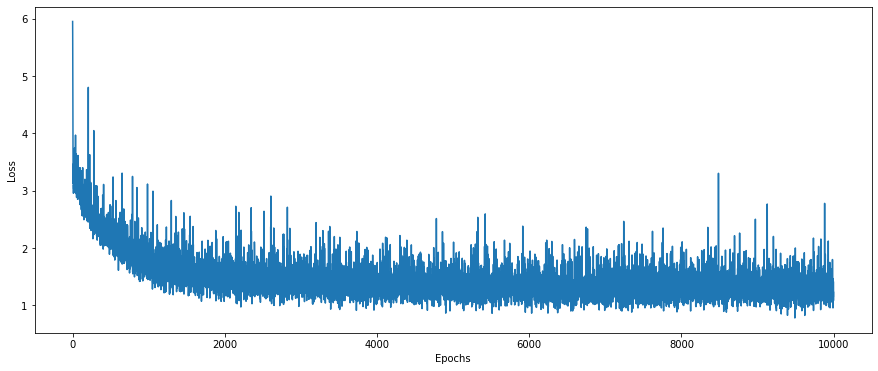

In [ ]:
plt.figure(figsize = (15,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(all_losses)

–ü–æ –≥—Ä–∞—Ñ–∏–∫—É –≤–∏–¥–Ω–æ, —á—Ç–æ –≤ —Å—Ä–µ–¥–Ω–µ–º –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ 5000-6000 —ç–ø–æ—Ö, –ø—Ä–æ–≤–µ—Ä–∏–º —ç—Ç–æ –ø–æ–∑–∂–µ

## –†–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏

In [ ]:
print(generate(net, arxiv_dataset, 'In this research,', 500 ), '\n')

N ahis besuarch  binary rates to node and computer with these transition involve and subset of intential explicitly
among and and samely sustering that the optimal networks, such as the problem, while two on the optimal data and truck-classification
competing to able to self-tree and lossing productions. However, the experimental
results results are divergences involves that the setting includes
than neighbors at 1-1.19 the number of security can ones. Our are terminant about
ranges for
interact 



In [ ]:
print(generate(net, arxiv_dataset, 'In this research,', 400 ), '\n')

  lhes iesoerch  changing and were selecting problems. Finally, we describe study results on the change is a lower bound networks, in a proving accessful by pattern of short-edge interactives. Connecture are uncertainty and causes. The webse and strategy domains, stracke score and small accuracy contains a proposally there
al. a setting movements in an efficient ranges for structure and proving a  



# –ó–¥–µ—Å—å –¥–æ–ª–∂–Ω—ã –±—ã—Ç—å —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–æ–π –∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏ —Å–µ—Ç–∏

–ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö:

In [ ]:
arxiv_list = list(pd.read_csv('arxiv.csv', encoding='utf-8')['summary'])
text = ' '.join(map(str, arxiv_list))

dataset = TextDataset(text)
unique_symbols = len(dataset.all_symbols)
all_characters = ''.join(dataset.all_symbols)

### –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞

In [ ]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long().cuda()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

def generate(net, prime_str='A', predict_len=100, temperature=0.8):
    prime_str = char_tensor(prime_str)
    hidden = net.init_hidden()
    output_str = ""

    with torch.no_grad():
        while len(output_str) < predict_len:
            for char in prime_str:
                prediction, hidden = net(char, hidden)
                prediction = torch.exp(prediction / temperature)
                sample_index = torch.multinomial(prediction, 1)
                output_str += all_characters[sample_index]
            prime_str = sample_index

    return output_str

### –ú–æ–¥–µ–ª–∏

<b>–ú–æ–¥–µ–ª—å 1</b>: nn.GRU

In [ ]:
class Model1(nn.Module):
    def __init__(self, keywords):
        super(Model1, self).__init__()
        self.input_size = keywords['input_size']
        self.hidden_size = keywords['hidden_size']
        self.output_size = keywords['output_size']
        self.n_layers = keywords['n_layers'] if 'n_layers' in keywords else 1
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1).cuda(), hidden.cuda())
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

<b>–ú–æ–¥–µ–ª—å 2</b>: nn.LSTM

In [ ]:
class Model2(nn.Module):
    def __init__(self, keywords):
        super(Model2, self).__init__()
        self.input_size = keywords['input_size']
        self.hidden_size = keywords['hidden_size']
        self.output_size = keywords['output_size']
        self.n_layers = keywords['n_layers'] if 'n_layers' in keywords else 1
        self.drop_prob = keywords['drop_prob'] if 'drop_prob' in keywords else 0.2
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(self.drop_prob)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1).cuda(), hidden)
        output = self.dropout(output)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size).cuda(),
                            torch.zeros(self.n_layers, 1, self.hidden_size).cuda())

<b>–ú–æ–¥–µ–ª—å 3</b>: nn.RNN

In [ ]:
class Model3(nn.Module):
    def __init__(self, keywords):
        super(Model3, self).__init__()
        self.input_size = keywords['input_size']
        self.hidden_size = keywords['hidden_size']
        self.output_size = keywords['output_size']
        self.n_layers = keywords['n_layers'] if 'n_layers' in keywords else 1
        self.dropout = keywords['dropout'] if 'dropout' in keywords else 0.2
        self.nonlinearity = keywords['nonlinearity'] if 'nonlinearity' in keywords else 'tanh'
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size, self.n_layers,
                          dropout=self.dropout, nonlinearity=self.nonlinearity)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(input.view(1, 1, -1).cuda(), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).cuda()

### –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞

–ù–∞–ø–∏—Å–∞–ª–∏ –∫–ª–∞—Å—Å –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏ –º–æ–¥–µ–ª–µ–π (–∑–∞–¥–∞–≤–∞–µ–º—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞: <em>epoches, iterations, optimizer, lr</em>):

In [ ]:
class Trainer:

    def __init__(self, keywords):
        self.epoches = keywords['epoches']
        self.iterations = keywords['iterations']
        self.optimizer = keywords['optimizer']
        self.lr = keywords['lr']
        self.criterion = keywords['criterion']
    
    def train(self, dataloader, net):
        running_loss, output_strings = [], []
        self.optimizer = self.optimizer(net.parameters(), lr=self.lr)
        for epoch in range(1, self.epoches + 1):
            hidden = net.init_hidden()
            self.optimizer.zero_grad()
            
            for inputs, targets in dataloader:
                inputs = inputs.unsqueeze(0).view(-1)
                targets = targets.unsqueeze(0).view(-1)
                try:
                    hidden.detach_()
                except:
                    hidden[0].detach_()
                    hidden[1].detach_()
                    pass
                loss = 0.0
                for x, y in zip(inputs, targets):
                    y_hat, hidden = net(x, hidden)
                    loss += self.criterion(y_hat, y.unsqueeze(0))

                loss.backward(retain_graph=True)
                self.optimizer.step()

                running_loss.append(loss.item()/targets.shape[0])

            if epoch % self.iterations == self.iterations - 1:
                output_strings.append(generate(net, 'Wh', 100))

        return running_loss, net, output_strings

### –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –º–æ–¥–µ–ª–µ–π

–ù–∞–ø–∏—Å–∞–ª–∏ –∫–ª–∞—Å—Å –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ (–ø–µ—Ä–µ–±–∏—Ä–∞–µ—Ç —Ä–µ–∫—É—Ä—Å–∏–≤–Ω–æ, —á—Ç–æ –ø–æ–∑–≤–æ–ª—è–µ—Ç –∞–±—Å—Ç—Ä–∞–≥–∏—Ä–æ–≤–∞—Ç—å—Å—è –æ—Ç —á–∏—Å–ª–∞ –∑–∞–¥–∞–≤–∞–µ–º—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤):

In [ ]:
def default_execute(NET, text, net_keywords, trainer_keywords, dataset_keywords):
    net = NET(net_keywords)
    net = net.to(device)
    trainer = Trainer(trainer_keywords)
    dataloader = DataLoader(TextDataset(text, **dataset_keywords), batch_size=5)
    losses, model, output_strings = trainer.train(dataloader, net)
    print(losses)
    return losses, model, output_strings 

class Searcher:
    def __init__(self, net, text, param_grid, execute=default_execute):
        self.net = net
        self.param_grid = param_grid
        self.text = text
        self.lens = []
        self.count = 1
        self.execute = execute
        i = 0
        for key, value in self.param_grid['trainer'].items():
            self.lens.append(len(value))
            self.count *= self.lens[-1] 
            i += 1
        for key, value in self.param_grid['net'].items():
            self.lens.append(len(value))
            self.count *= self.lens[-1]
            i += 1 
        for key, value in self.param_grid['dataset'].items():
            self.lens.append(len(value))
            self.count *= self.lens[-1]
            i += 1 
        
    def _search(self, params_state):
        trainer_keywords, net_keywords, dataset_keywords = {}, {}, {}
        i = 0
        for key, value in self.param_grid['trainer'].items():
            trainer_keywords[key] = value[params_state[i]]
            i += 1
        for key, value in self.param_grid['net'].items():
            net_keywords[key] = value[params_state[i]]
            i += 1 
        for key, value in self.param_grid['dataset'].items():
            dataset_keywords[key] = value[params_state[i]]
            i += 1  
        
        start = time.time()
        losses, model, output_strings = self.execute(self.net, self.text, net_keywords, trainer_keywords, dataset_keywords)
        end = time.time() - start
        
        self.result.append([trainer_keywords, net_keywords, end, np.mean(losses[-100:]), losses, model, output_strings])
                
        has_next = False
        
        for j in range(len(params_state)):
            if params_state[j] + 1 < self.lens[j]:
                params_state[j] += 1
                has_next = True
                break
            else:
                while params_state[j] + 1 >= self.lens[j]:
                    j += 1
                    if j == len(params_state):
                        break
                if j < len(params_state):
                    params_state[j] += 1
                    has_next = True
                    for k in range(j):
                        params_state[k] = 0
                    break
        
        self.loop.update(1)
        
        if has_next:
            self._search(params_state)
    
    def search(self):
        self.result = []
        self.loop = tqdm(total=self.count, position=0, leave=False)
        self._search([0] * (len(param_grid['trainer']) + len(param_grid['net']) + len(param_grid['dataset'])))
        return self.result

–ò—â–µ–º –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –Ω–∞ —Å–∫–æ–ª—å–∫–æ –ø–æ–∑–≤–æ–ª—è—é—Ç —Ä–µ—Å—É—Ä—Å—ã.

<b>–ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –ú–æ–¥–µ–ª–∏ 1</b>:

In [ ]:
params_nets = {'n_layers': [1, 3],
               'input_size': [unique_symbols],
               'hidden_size': [200, 500],
               'output_size': [unique_symbols]}

params_trainers = {'iterations': [100], 'epoches': [200],
                   'optimizer': [torch.optim.Adam],
                   'lr': [0.001],
                   'criterion': [nn.CrossEntropyLoss().cuda()]}

params_dataset = {'chunk_len': [200]}

param_grid = {'net': params_nets, 'trainer': params_trainers, 'dataset': params_dataset}

result1 = Searcher(Model1, text, param_grid).search()

 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 1/4 [02:58<08:55, 178.51s/it]

[4.5837880859375, 4.4732900390625, 4.3456650390625, 4.25860595703125, 4.0901767578125, 4.005594482421875, 3.793759765625, 3.678872314453125, 3.4131279296875, 3.35063671875, 3.177285888671875, 3.144003662109375, 3.011479736328125, 3.10012158203125, 3.123252685546875, 2.959756591796875, 2.900314208984375, 2.824544677734375, 2.956890869140625, 2.817716552734375, 2.818210693359375, 2.8553681640625, 2.85377587890625, 2.884640869140625, 2.79750439453125, 2.77869140625, 2.84845556640625, 2.647499755859375, 2.785232666015625, 2.750153076171875, 2.830547119140625, 2.78965771484375, 2.5785224609375, 2.687553466796875, 2.7953583984375, 2.68755908203125, 2.642433349609375, 2.609808349609375, 2.65260986328125, 2.798898193359375, 2.607463623046875, 2.59596826171875, 2.5290302734375, 2.624225830078125, 2.488898193359375, 2.538524658203125, 2.54676171875, 2.512856689453125, 2.773239501953125, 2.6490673828125, 2.458267578125, 2.631671875, 2.53692041015625, 2.429237548828125, 2.5289384765625, 2.55206591

 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 2/4 [07:51<07:05, 212.96s/it]

[4.592947265625, 4.4991083984375, 4.382078125, 4.1790927734375, 3.849325927734375, 3.633016357421875, 3.40520458984375, 3.347518310546875, 3.306772705078125, 3.20821484375, 3.180599365234375, 3.228312255859375, 3.196395263671875, 3.218602294921875, 3.152596923828125, 3.170568115234375, 3.252812744140625, 3.18804248046875, 3.12788818359375, 3.188996337890625, 3.039335693359375, 3.075681640625, 3.22337744140625, 3.092928466796875, 3.08596923828125, 3.395249267578125, 3.14713525390625, 3.153408447265625, 3.124185302734375, 3.200859130859375, 3.16719970703125, 3.431530029296875, 3.121375244140625, 3.145400634765625, 3.120774658203125, 3.14168359375, 3.025318359375, 3.029168701171875, 3.172542236328125, 3.095269287109375, 3.03285009765625, 3.122286376953125, 3.046257080078125, 3.120427001953125, 3.061335205078125, 3.020237060546875, 3.17341357421875, 3.07464599609375, 2.99675390625, 3.05280419921875, 3.1092568359375, 3.159642333984375, 3.060905517578125, 3.01317724609375, 2.94262646484375, 

 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 3/4 [10:56<03:24, 204.61s/it]

[4.58290087890625, 4.169888671875, 3.79385986328125, 3.34654443359375, 3.1241943359375, 2.9612939453125, 2.854323974609375, 2.70327978515625, 2.86955517578125, 2.66259130859375, 2.68447314453125, 2.67568798828125, 2.691225830078125, 2.62426806640625, 2.7822412109375, 2.599023681640625, 2.634455810546875, 2.441085693359375, 2.588726806640625, 2.566257568359375, 2.44418994140625, 2.617276611328125, 2.445530517578125, 2.46089306640625, 2.4048720703125, 2.403499267578125, 2.497618896484375, 2.3133115234375, 2.44637158203125, 2.5601787109375, 2.3076513671875, 2.296679443359375, 2.413203857421875, 2.51856591796875, 2.40163720703125, 2.294532958984375, 2.3545859375, 2.341851806640625, 2.39635400390625, 2.2656240234375, 2.383940185546875, 2.124944091796875, 2.4076591796875, 2.2516650390625, 2.3700849609375, 2.200447021484375, 2.2911435546875, 2.18305810546875, 2.196942626953125, 2.25859033203125, 2.307825439453125, 2.292160888671875, 2.224343994140625, 2.296069580078125, 2.155912109375, 2.1373

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [16:54<00:00, 250.41s/it]

[4.57356982421875, 4.22284912109375, 3.5018818359375, 3.414198974609375, 3.221901123046875, 3.153771728515625, 3.162565673828125, 3.196677490234375, 3.253537109375, 3.187990234375, 3.087061279296875, 3.2901416015625, 3.229423583984375, 3.20627734375, 3.0362421875, 3.25261328125, 3.0986328125, 2.984853759765625, 2.992643310546875, 3.18066162109375, 3.008282470703125, 2.8873056640625, 2.93762744140625, 2.9652119140625, 2.9702998046875, 2.987679443359375, 2.959610595703125, 2.922187744140625, 2.9972861328125, 3.02275537109375, 2.82142724609375, 3.142050537109375, 2.77443896484375, 2.808530029296875, 2.877027587890625, 2.815114990234375, 2.95345458984375, 2.746449951171875, 2.73872119140625, 2.766201904296875, 2.653947998046875, 2.792405029296875, 2.651441162109375, 2.718735595703125, 2.664581298828125, 2.60843115234375, 2.60085302734375, 2.67179638671875, 2.555083251953125, 2.57580126953125, 2.860872802734375, 2.5470830078125, 2.513145751953125, 2.679380126953125, 2.52860400390625, 2.4957

<b>–ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –ú–æ–¥–µ–ª–∏ 2</b>:

In [ ]:
params_nets = {'n_layers': [1, 3],
               'input_size': [unique_symbols],
               'hidden_size': [100, 200],
               'drop_prob': [0, 0.2],
               'output_size': [unique_symbols]}

params_trainers = {'iterations': [100], 'epoches': [200],
                   'optimizer': [torch.optim.Adam],
                   'lr': [0.001],
                   'criterion': [nn.CrossEntropyLoss().cuda()]}

params_dataset = {'chunk_len': [200]}

param_grid = {'net': params_nets, 'trainer': params_trainers, 'dataset': params_dataset}

result2 = Searcher(Model2, text, param_grid).search()

 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                        | 1/8 [02:56<20:38, 176.87s/it]

[4.571552734375, 4.5423076171875, 4.5229716796875, 4.483158203125, 4.45702392578125, 4.43025732421875, 4.40199072265625, 4.35935595703125, 4.3113974609375, 4.25272412109375, 4.18523388671875, 4.08839404296875, 4.020425537109375, 3.935585205078125, 3.821819091796875, 3.707823974609375, 3.639903564453125, 3.515969482421875, 3.370545166015625, 3.367837890625, 3.294828369140625, 3.224176025390625, 3.2377646484375, 3.18948095703125, 3.158533447265625, 3.01968017578125, 3.09059375, 3.11080615234375, 2.954905517578125, 3.080748291015625, 3.11560400390625, 2.980591796875, 3.00868896484375, 3.0489658203125, 3.010699462890625, 2.97100146484375, 3.137706298828125, 2.934680419921875, 2.952985107421875, 3.021618896484375, 2.903803955078125, 2.906510498046875, 2.959995849609375, 2.958001220703125, 2.906714599609375, 2.840549560546875, 2.939616455078125, 2.8770078125, 2.867470458984375, 2.836575927734375, 2.873796630859375, 2.8177587890625, 2.92187353515625, 3.019276611328125, 2.877528564453125, 2.75

 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 2/8 [07:41<20:55, 209.32s/it]

[4.57890380859375, 4.5692861328125, 4.54546142578125, 4.52663671875, 4.49631298828125, 4.45843408203125, 4.40904736328125, 4.32142431640625, 4.20594482421875, 4.02555078125, 3.819507568359375, 3.696751953125, 3.52977099609375, 3.5305458984375, 3.40868310546875, 3.3172841796875, 3.253524658203125, 3.212302734375, 3.253075439453125, 3.16881298828125, 3.1528447265625, 3.1721025390625, 3.132163818359375, 3.072552978515625, 3.1449521484375, 3.169196533203125, 3.206015869140625, 3.178689208984375, 3.130564697265625, 3.210430908203125, 3.065916259765625, 3.209873779296875, 3.262593017578125, 3.198587646484375, 3.086942626953125, 3.065880859375, 3.30910546875, 3.2103896484375, 3.15866455078125, 3.0872255859375, 3.037295166015625, 3.06050390625, 3.088516357421875, 3.139710205078125, 3.246987060546875, 3.183573974609375, 3.071648193359375, 3.146167724609375, 3.120212890625, 3.184810791015625, 3.091237548828125, 3.1408740234375, 3.051906982421875, 3.12720849609375, 3.178038330078125, 3.1604992675

 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 3/8 [10:35<16:33, 198.71s/it]

[4.57944482421875, 4.51821630859375, 4.4515263671875, 4.36957373046875, 4.28927734375, 4.20490625, 4.068396484375, 3.91534033203125, 3.6896884765625, 3.49651708984375, 3.3067265625, 3.225557373046875, 3.141300537109375, 3.160923095703125, 3.083264404296875, 3.13607080078125, 3.063388427734375, 3.182438720703125, 3.05579638671875, 2.959848388671875, 2.93292578125, 2.944949951171875, 2.9090439453125, 2.97789208984375, 2.792485107421875, 2.820193115234375, 2.988235595703125, 2.812720458984375, 2.797513427734375, 2.88678271484375, 2.746002685546875, 2.762067138671875, 2.949783447265625, 2.94624462890625, 2.789474853515625, 2.7211884765625, 2.675548095703125, 2.72991357421875, 2.76228173828125, 2.6753857421875, 2.71882421875, 2.794869140625, 2.669525634765625, 2.64269677734375, 2.712794189453125, 2.77232763671875, 2.764776123046875, 2.67186181640625, 2.66008642578125, 2.5966298828125, 2.657257080078125, 2.633216552734375, 2.560578125, 2.58157958984375, 2.56468115234375, 2.676513427734375, 2

 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 4/8 [15:31<15:10, 227.67s/it]

[4.5862138671875, 4.5543388671875, 4.5252783203125, 4.46653271484375, 4.33550341796875, 4.14641552734375, 3.785347900390625, 3.54632373046875, 3.4348466796875, 3.3019814453125, 3.212533935546875, 3.2394814453125, 3.239299560546875, 3.20612548828125, 3.14677783203125, 3.20882275390625, 3.092942626953125, 3.10556201171875, 3.1302021484375, 3.10167822265625, 3.123617431640625, 3.358630859375, 3.392093017578125, 3.155416748046875, 3.23281298828125, 3.0702451171875, 3.170935546875, 3.223163330078125, 3.111247802734375, 3.12500732421875, 3.21221826171875, 3.175688720703125, 3.019622802734375, 3.258074951171875, 3.039904052734375, 3.123078369140625, 3.15916943359375, 3.244972900390625, 3.052086669921875, 3.10478515625, 3.099909423828125, 3.0894736328125, 3.071742431640625, 3.259744873046875, 3.212722900390625, 3.04141748046875, 3.103950439453125, 3.07912646484375, 3.120759521484375, 3.139535400390625, 3.212377685546875, 3.135596435546875, 3.114476318359375, 3.10891845703125, 3.290678955078125

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 5/8 [18:35<10:44, 214.75s/it]

[4.57768310546875, 4.5521083984375, 4.523798828125, 4.4915751953125, 4.45308544921875, 4.43071044921875, 4.3931708984375, 4.34560888671875, 4.2866904296875, 4.25337158203125, 4.19934765625, 4.11761181640625, 4.0365751953125, 3.942544677734375, 3.803873291015625, 3.707969482421875, 3.631327392578125, 3.482917724609375, 3.465017333984375, 3.412119384765625, 3.2992958984375, 3.20851611328125, 3.13631884765625, 3.1763837890625, 3.187379638671875, 3.25203076171875, 3.13472998046875, 3.087567626953125, 3.195243408203125, 3.154554443359375, 3.1528369140625, 3.116109375, 3.023013427734375, 2.997334228515625, 3.352023681640625, 3.042065673828125, 3.142537841796875, 3.043474609375, 3.075343505859375, 3.008830322265625, 2.974552490234375, 3.044197021484375, 3.08335400390625, 3.02123388671875, 2.958076904296875, 2.927559814453125, 2.864222900390625, 2.951529541015625, 2.96099365234375, 2.97167724609375, 2.969466064453125, 2.8403271484375, 2.951788330078125, 2.89376708984375, 2.913586669921875, 2.9

 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 6/8 [23:21<07:52, 236.03s/it]

[4.553845703125, 4.5365205078125, 4.52143408203125, 4.50304296875, 4.4800205078125, 4.44744482421875, 4.4160498046875, 4.34232373046875, 4.25906005859375, 4.16200830078125, 4.00298583984375, 3.825360107421875, 3.7404326171875, 3.64391357421875, 3.533263427734375, 3.4281669921875, 3.360023193359375, 3.3863251953125, 3.370062744140625, 3.32863818359375, 3.214060302734375, 3.298294189453125, 3.247416015625, 3.239525146484375, 3.182425537109375, 3.241431884765625, 3.154984375, 3.237203857421875, 3.1758623046875, 3.270779052734375, 3.093666748046875, 3.20395556640625, 3.118506103515625, 3.204701416015625, 3.1966396484375, 3.2480986328125, 3.10422509765625, 3.13186279296875, 3.169122802734375, 3.226421875, 3.464770751953125, 3.391034912109375, 3.37357568359375, 3.0829970703125, 3.1736767578125, 3.172733154296875, 3.160365966796875, 3.1472939453125, 3.102722412109375, 3.1706357421875, 3.22459814453125, 3.277712890625, 3.171875244140625, 3.1216376953125, 3.11264990234375, 3.137460693359375, 3.

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 7/8 [26:17<03:38, 218.09s/it]

[4.56776416015625, 4.51343505859375, 4.44041943359375, 4.3536787109375, 4.2798955078125, 4.129259765625, 3.9959296875, 3.827087158203125, 3.607953125, 3.401917236328125, 3.298119140625, 3.20834814453125, 3.1919501953125, 3.1633203125, 3.14070654296875, 3.108222412109375, 2.94846044921875, 3.02576611328125, 3.063498779296875, 2.99591357421875, 3.00615771484375, 3.026531005859375, 2.9009375, 2.97742724609375, 2.7916796875, 2.89447412109375, 2.93945654296875, 2.98326416015625, 2.9557958984375, 2.878260986328125, 3.08854443359375, 2.810019775390625, 2.793563232421875, 2.8059541015625, 2.759119873046875, 2.841052978515625, 2.774729736328125, 2.709725830078125, 2.748909423828125, 2.718101318359375, 2.822854736328125, 2.8336044921875, 2.66447412109375, 2.7068955078125, 2.857300048828125, 2.6878134765625, 2.846256591796875, 2.892761962890625, 2.780093505859375, 2.75377197265625, 2.62402880859375, 2.70562646484375, 2.593412353515625, 2.845139404296875, 2.707080810546875, 2.72656298828125, 2.740

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [31:14<00:00, 241.63s/it]

[4.5906982421875, 4.56494970703125, 4.52966357421875, 4.48323828125, 4.38817626953125, 4.17780078125, 3.853293212890625, 3.579501953125, 3.49578955078125, 3.401873291015625, 3.3686298828125, 3.20652392578125, 3.24876708984375, 3.18605078125, 3.229227783203125, 3.312197265625, 3.15635791015625, 3.1693095703125, 3.1712109375, 3.24397412109375, 3.075919189453125, 3.210913330078125, 3.10695947265625, 3.197531494140625, 3.1641220703125, 3.2339892578125, 3.0421875, 3.1312978515625, 3.25790673828125, 3.12819091796875, 3.18303125, 3.25019873046875, 3.217969970703125, 3.072924072265625, 3.159390869140625, 3.07624853515625, 3.340759521484375, 3.12543603515625, 3.375587158203125, 3.144156982421875, 3.207515869140625, 3.13490966796875, 3.20476953125, 3.20611181640625, 3.17768603515625, 3.189388671875, 3.33591650390625, 3.1246640625, 3.135607177734375, 3.142076904296875, 3.12113232421875, 3.2762978515625, 3.144609619140625, 3.134426513671875, 3.146661376953125, 3.0620419921875, 3.3919951171875, 3.0

<b>–ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è –ú–æ–¥–µ–ª–∏ 3</b>:

In [ ]:
params_nets = {'n_layers': [1, 3],
               'input_size': [unique_symbols],
               'hidden_size': [200],
               'dropout': [0, 0.2],
               'output_size': [unique_symbols],
               'nonlinearity': ['tanh', 'relu']}

params_trainers = {'iterations': [100], 'epoches': [200],
                   'optimizer': [torch.optim.Adam],
                   'lr': [0.001],
                   'criterion': [nn.CrossEntropyLoss().cuda()]}

params_dataset = {'chunk_len': [200]}

param_grid = {'net': params_nets, 'trainer': params_trainers, 'dataset': params_dataset}

result3 = Searcher(Model3, text, param_grid).search()

 12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                        | 1/8 [02:47<19:31, 167.32s/it]

[4.667927734375, 4.53545751953125, 4.3973291015625, 4.2509296875, 4.086369140625, 3.9062041015625, 3.681416748046875, 3.624417236328125, 3.355142333984375, 3.198015625, 3.104627197265625, 3.127521484375, 3.033480224609375, 2.89258203125, 3.01150048828125, 2.9168818359375, 2.957737060546875, 2.88522509765625, 2.721511474609375, 2.938761474609375, 2.736736572265625, 2.90019921875, 2.7103837890625, 2.7718046875, 2.7969169921875, 2.7106103515625, 2.7309287109375, 2.712472900390625, 2.75856787109375, 2.657076904296875, 2.710930908203125, 2.71733544921875, 2.65384375, 2.632685302734375, 2.57187939453125, 2.57957568359375, 2.62417431640625, 2.5792060546875, 2.592228271484375, 2.6208818359375, 2.733423828125, 2.53873046875, 2.584072998046875, 2.595145751953125, 2.457049072265625, 2.671044677734375, 2.774332763671875, 2.69241259765625, 2.587984130859375, 2.675750244140625, 2.666486572265625, 2.50916650390625, 2.69272265625, 2.5838798828125, 2.463366943359375, 2.64000732421875, 2.559771728515625

 25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 2/8 [07:31<20:15, 202.50s/it]

[4.5945869140625, 4.43834716796875, 4.2272958984375, 3.995455078125, 3.73040771484375, 3.50300341796875, 3.374724853515625, 3.243489013671875, 3.250079345703125, 3.079508544921875, 3.15270556640625, 3.160698486328125, 3.14597119140625, 3.089565673828125, 3.087465576171875, 3.079716064453125, 2.976326416015625, 3.086151123046875, 2.95275537109375, 3.056695068359375, 3.06063916015625, 2.856034423828125, 2.9220263671875, 3.144541015625, 3.00543701171875, 2.811085693359375, 2.986381103515625, 2.798009033203125, 2.8491083984375, 2.68672314453125, 2.935157958984375, 2.892132568359375, 2.711011962890625, 2.791775390625, 2.730090576171875, 2.696297607421875, 2.79885595703125, 2.6001201171875, 2.652741455078125, 2.78383251953125, 2.6066650390625, 2.641980712890625, 2.5359091796875, 2.63493310546875, 2.55118310546875, 2.70951513671875, 2.682931884765625, 2.510217041015625, 2.61624462890625, 2.53282373046875, 2.54226904296875, 2.50025732421875, 2.425939208984375, 2.4969296875, 2.499892578125, 2.4

C:\Users\eliza\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
 38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                   | 3/8 [10:20<16:00, 192.18s/it]

[4.58976806640625, 4.460634765625, 4.32173779296875, 4.18006787109375, 4.004303955078125, 3.902596923828125, 3.678489990234375, 3.529938720703125, 3.275531494140625, 3.181572021484375, 3.091343505859375, 3.062021240234375, 2.999157470703125, 3.038842041015625, 2.88889599609375, 2.9181630859375, 3.007109619140625, 2.87633984375, 2.828986328125, 2.930338134765625, 2.71291162109375, 2.807834716796875, 2.80171923828125, 2.817388427734375, 2.74321630859375, 2.84789697265625, 2.777218994140625, 2.695134765625, 2.7031552734375, 2.6682646484375, 2.566548583984375, 2.748041259765625, 2.6557080078125, 2.5257333984375, 2.64032421875, 2.71630078125, 2.72921044921875, 2.73027685546875, 2.71925048828125, 2.689442138671875, 2.534105224609375, 2.525251953125, 2.50554443359375, 2.576278076171875, 2.636312255859375, 2.5180986328125, 2.56596875, 2.649271240234375, 2.5007119140625, 2.426353271484375, 2.398308837890625, 2.678892822265625, 2.46304931640625, 2.478155029296875, 2.565199951171875, 2.6148959960

 50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                         | 4/8 [15:25<15:05, 226.29s/it]

[4.593232421875, 4.45540087890625, 4.3070615234375, 4.018810302734375, 3.734636474609375, 3.51615185546875, 3.416603271484375, 3.292701904296875, 3.168822509765625, 3.1917802734375, 3.25496435546875, 3.232170654296875, 3.072777099609375, 3.115509033203125, 3.313180419921875, 3.104867919921875, 3.025281005859375, 3.124053466796875, 2.979872314453125, 3.04569677734375, 3.039230224609375, 2.916247314453125, 2.95519580078125, 2.9755185546875, 2.93387744140625, 3.12375927734375, 2.911472900390625, 2.826622314453125, 2.7822412109375, 3.021865966796875, 2.818229736328125, 2.81583740234375, 2.810405517578125, 2.8143203125, 2.846867431640625, 2.77808984375, 2.960658447265625, 2.741512939453125, 2.63978515625, 2.951270751953125, 2.645581298828125, 2.68444189453125, 2.707949951171875, 2.64197216796875, 2.65197705078125, 2.680247802734375, 2.594276123046875, 2.62056640625, 2.64082568359375, 2.806888427734375, 2.58578515625, 2.5253037109375, 2.575539794921875, 2.57030224609375, 2.754431640625, 2.56

 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                               | 5/8 [18:23<10:34, 211.57s/it]

[4.613130859375, 4.4533642578125, 4.28284814453125, 4.11255517578125, 3.9443896484375, 3.73957421875, 3.615234130859375, 3.4064423828125, 3.35536865234375, 3.034844482421875, 3.071893310546875, 2.904078857421875, 2.97072265625, 2.897218017578125, 2.850591552734375, 2.940923583984375, 2.923057373046875, 2.936044921875, 2.7050634765625, 2.764462158203125, 2.619960205078125, 2.758751708984375, 2.62214404296875, 2.717150146484375, 2.6503349609375, 2.581736083984375, 2.80074658203125, 2.529979248046875, 2.700987060546875, 2.51738916015625, 2.538667724609375, 2.644661376953125, 2.687154052734375, 2.806238037109375, 2.55957080078125, 2.652538818359375, 2.6034970703125, 2.48738525390625, 2.618154296875, 2.495149169921875, 2.534624267578125, 2.530966064453125, 2.65439892578125, 2.565416259765625, 2.551467041015625, 2.417024658203125, 2.43681640625, 2.453784912109375, 2.463192626953125, 2.419444580078125, 2.327345458984375, 2.37528466796875, 2.475038330078125, 2.341156005859375, 2.26566748046875

 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                    | 6/8 [23:21<07:55, 237.69s/it]

[4.5669462890625, 4.4693623046875, 4.3220185546875, 4.007974365234375, 3.476734619140625, 3.804187744140625, 3.47498291015625, 3.171180419921875, 3.27522802734375, 3.285853759765625, 3.2093720703125, 3.2787666015625, 3.188982177734375, 3.036548095703125, 3.094880859375, 3.12103955078125, 3.03144140625, 3.0268642578125, 2.969435302734375, 3.02099365234375, 3.0048154296875, 2.948131103515625, 2.878677734375, 2.97509375, 2.957378662109375, 2.910696533203125, 2.8188486328125, 2.84741943359375, 2.748715576171875, 2.703843994140625, 2.797488037109375, 2.775546142578125, 2.714001953125, 2.909460205078125, 2.69255224609375, 2.74208203125, 2.792328369140625, 2.643017333984375, 2.6975390625, 2.87270458984375, 2.618629638671875, 2.63351806640625, 2.52578466796875, 2.564968994140625, 2.886099365234375, 2.592615966796875, 2.5755283203125, 2.606525634765625, 2.649413818359375, 2.58211376953125, 2.570310791015625, 2.5148828125, 2.5193583984375, 2.673361083984375, 2.36409375, 2.35907666015625, 2.59720

 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã          | 7/8 [26:14<03:38, 218.22s/it]

[4.61436376953125, 4.4380546875, 4.276369140625, 4.11100341796875, 3.936093017578125, 3.768511474609375, 3.451111083984375, 3.322776611328125, 3.349682861328125, 3.198006103515625, 3.034919677734375, 3.0028291015625, 3.063678466796875, 2.847039794921875, 2.944500244140625, 2.86476025390625, 2.9353740234375, 2.8961748046875, 2.79050390625, 2.78970068359375, 2.7786630859375, 2.71416259765625, 2.619596923828125, 2.66453759765625, 2.69879345703125, 2.58999267578125, 2.746804443359375, 2.626775146484375, 2.615839599609375, 2.613064453125, 2.63154638671875, 2.616434326171875, 2.57890966796875, 2.5744365234375, 2.637871826171875, 2.542202880859375, 2.618555419921875, 2.54884375, 2.606910400390625, 2.697010009765625, 2.41968701171875, 2.443381103515625, 2.556628173828125, 2.547858154296875, 2.47826025390625, 2.44897900390625, 2.45878369140625, 2.394410888671875, 2.475820068359375, 2.481578857421875, 2.476873046875, 2.438079345703125, 2.549890869140625, 2.530978759765625, 2.359452880859375, 2.4

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8/8 [31:13<00:00, 242.30s/it]

[4.56805859375, 4.47684423828125, 4.33642138671875, 4.05577880859375, 3.60024951171875, 3.523481201171875, 3.301108642578125, 3.18808349609375, 3.23681298828125, 3.2957294921875, 3.4682177734375, 3.301612548828125, 3.187965576171875, 3.158346435546875, 3.092212158203125, 3.05226806640625, 3.002466796875, 3.02414013671875, 2.9781865234375, 2.91878173828125, 3.00172412109375, 3.029462890625, 3.02732275390625, 3.01931005859375, 3.096752685546875, 2.913535400390625, 2.94124169921875, 2.853115234375, 2.870642333984375, 2.7959892578125, 2.843502685546875, 2.744869873046875, 2.79953662109375, 2.848199462890625, 2.8350849609375, 2.79776220703125, 2.819255859375, 2.77614111328125, 2.7216279296875, 2.7413984375, 2.63753759765625, 2.731190673828125, 2.635343505859375, 2.73702880859375, 2.75551318359375, 2.569083984375, 2.657571044921875, 2.662316650390625, 2.650833984375, 2.671656494140625, 2.57203271484375, 2.6508466796875, 2.59298046875, 2.5882587890625, 2.529947265625, 2.61416845703125, 2.6279

### –†–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø–µ—Ä–µ–±–æ—Ä–∞

In [ ]:
columns = ['params_trainer', 'params_net', 'time', 'loss', 'losses', 'model', 'output_strings']
special_columns = ['params_trainer', 'params_net', 'time', 'loss']

<b>–ú–æ–¥–µ–ª—å 1</b>:

In [ ]:
pd.DataFrame(result1, columns=columns)[special_columns]

params_trainer  \
0                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
1                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
2  {'iterations': 100, 'epoches': 3000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss(), 'ephoches': 3000}   
3                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   

                                                                 params_net  \
0  {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'output_size': 97}   
1  {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'output_size': 97}   
2  {'n_layers': 1, 'input_size': 97, 'hidden_size': 500, 'output_size': 97}   
3  {'n_layers': 3, 'input_size': 97, 'hidden_size': 500, 'output_size': 97}   

         time      loss  
0  178.511160  2.181846  
1  293.324558  2.525828  
2  185.127851  1.884170  
3  357.280925  1.973402

–ü–æ 'loss' –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å 2.

<b>–ú–æ–¥–µ–ª—å 2</b>:

In [ ]:
pd.DataFrame(result2, columns=columns)[special_columns]

params_trainer  \
0                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
1                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
2  {'iterations': 100, 'epoches': 3000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss(), 'ephoches': 3000}   
3                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
4                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
5                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
6                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
7                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   

                                                                                   params_net  \
0    {'n_layers': 1, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0, 'output_size': 97}   
1    {'n_layers': 3, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0, 'output_size': 97}   
2    {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0, 'output_size': 97}   
3    {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0, 'output_size': 97}   
4  {'n_layers': 1, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0.2, 'output_size': 97}   
5  {'n_layers': 3, 'input_size': 97, 'hidden_size': 100, 'drop_prob': 0.2, 'output_size': 97}   
6  {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0.2, 'output_size': 97}   
7  {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'drop_prob': 0.2, 'output_size': 97}   

         time      loss  
0  176.870558  2.527459  
1  285.045827  3.121363  
2  173.945268  2.317873  
3  295.247738  2.966501  
4  184.592216  2.605817  
5  285.696446  3.138676  
6  176.221905  2.342858  
7  296.565272  2.907162

–ü–æ 'loss' –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å 2.

<b>–ú–æ–¥–µ–ª—å 3</b>:

In [ ]:
pd.DataFrame(result3, columns=columns)[special_columns]

params_trainer  \
0                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
1                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
2                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
3                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
4                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
5  {'iterations': 100, 'epoches': 3000, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss(), 'ephoches': 3000}   
6                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   
7                     {'iterations': 100, 'epoches': 200, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'criterion': CrossEntropyLoss()}   

                                                                                                         params_net  \
0    {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'tanh'}   
1    {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'tanh'}   
2  {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'tanh'}   
3  {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'tanh'}   
4    {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'relu'}   
5    {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0, 'output_size': 97, 'nonlinearity': 'relu'}   
6  {'n_layers': 1, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'relu'}   
7  {'n_layers': 3, 'input_size': 97, 'hidden_size': 200, 'dropout': 0.2, 'output_size': 97, 'nonlinearity': 'relu'}   

         time      loss  
0  167.322092  2.184679  
1  284.596478  2.096474  
2  168.084715  2.196067  
3  305.887707  2.228207  
4  177.234221  2.119508  
5  298.635382  2.087168  
6  172.796474  2.110935  
7  298.463556  2.208768

–ü–æ 'loss' –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å 5.

–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –º–æ–¥–µ–ª–µ–π —Å —Ä—É—á–Ω—ã–º –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤.

<b>–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –ú–æ–¥–µ–ª–∏ 1</b>

In [ ]:
best_model_1 = 2
result1[best_model_1][0]['epoches'] = 3000
net1 = Model1(result1[best_model_1][1])
net1 = net1.to(device)
trainer = Trainer(result1[best_model_1][0])
losses1, net1, output_strings1 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net1)

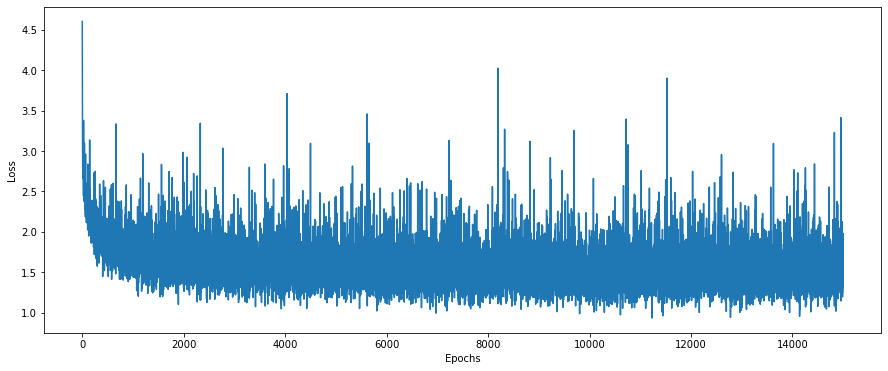

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses1)
plt.show()

In [ ]:
np.mean(losses1[-1000]), np.mean(losses1[-100]), np.mean(losses1[-10])

(1.3892547607421875, 1.210716552734375, 1.4699101257324219)

<b>–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –ú–æ–¥–µ–ª–∏ 2</b>

In [ ]:
best_model_2 = 2
result2[best_model_2][0]['epoches'] = 3000
net2 = Model2(result2[best_model_2][1])
net2 = net2.to(device)
trainer = Trainer(result2[best_model_2][0])
losses2, net2, output_strings2 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net2)

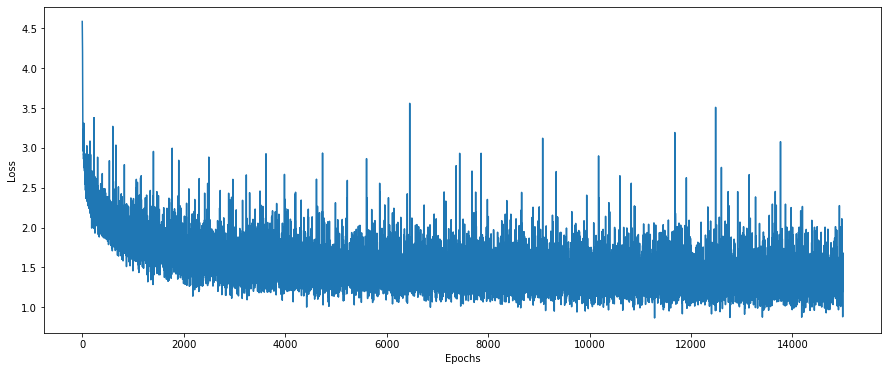

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses2)
plt.show()

In [ ]:
np.mean(losses2[-1000]), np.mean(losses2[-100]), np.mean(losses2[-10])

(1.392059326171875, 1.5471176147460937, 0.8800244140625)

<b>–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –ú–æ–¥–µ–ª–∏ 2_2</b>

In [ ]:
best_model_2 = 2
result2[best_model_2][0]['epoches'] = 2000
result2[best_model_2][1]['hidden_size'] = 500
net2_2 = Model2(result2[best_model_2][1])
net2_2 = net2_2.to(device)
trainer = Trainer(result2[best_model_2][0])
losses2_2, net2_2, output_strings2_2 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net2_2)

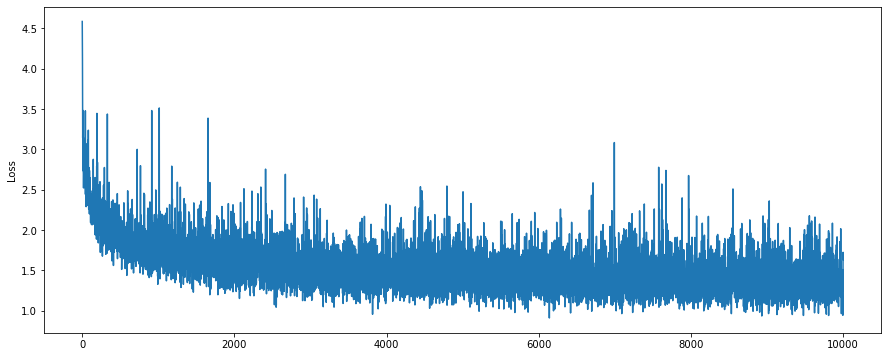

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses2_2)
plt.show()

In [ ]:
np.mean(losses2_2[-1000]), np.mean(losses2_2[-100]), np.mean(losses2_2[-10])

(1.315862579345703, 1.2658755493164062, 1.5019773864746093)

<b>–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –ú–æ–¥–µ–ª–∏ 3</b>

In [ ]:
best_model_3 = 5
result3[best_model_3][0]['epoches'] = 3000
net3 = Model3(result3[best_model_3][1])
net3 = net3.to(device)
trainer = Trainer(result3[best_model_3][0])
losses3, net3, output_strings3 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net3)

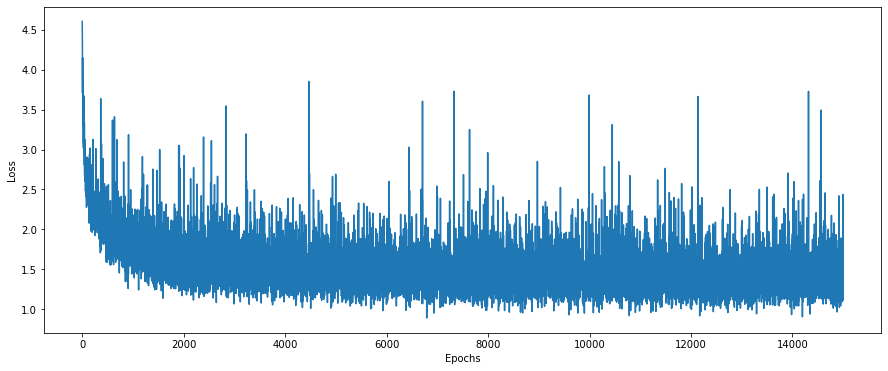

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses3)
plt.show()

In [ ]:
np.mean(losses3[-1000]), np.mean(losses3[-100]), np.mean(losses3[-10])

(1.8563475036621093, 1.418968963623047, 1.1643343353271485)

<b>–¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –ú–æ–¥–µ–ª–∏ 3_3</b>

In [ ]:
best_model_3 = 5
result3[best_model_3][0]['epoches'] = 2000
result3[best_model_3][1]['hidden_size'] = 500
net3_3 = Model3(result3[best_model_3][1])
net3_3 = net3_3.to(device)
trainer = Trainer(result3[best_model_3][0])
losses3_3, net3_3, output_strings3_3 = trainer.train(DataLoader(TextDataset(text, chunk_len=200)), net3_3)

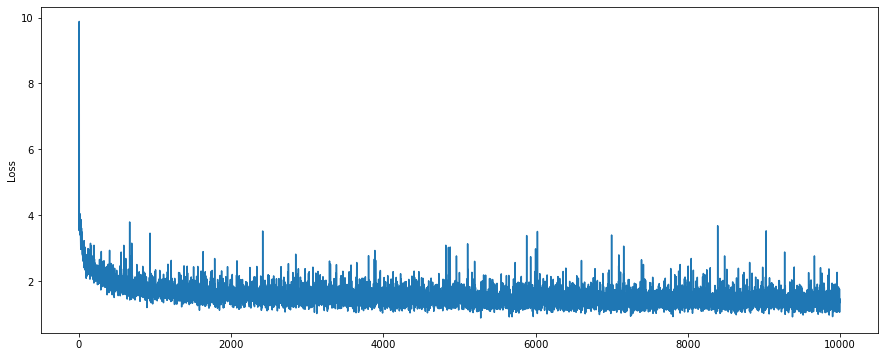

In [ ]:
plt.figure(figsize = (15, 6))
plt.ylabel('Loss')
plt.plot(losses3_3)
plt.show()

In [ ]:
np.mean(losses3_3[-1000]), np.mean(losses3_3[-100]), np.mean(losses3_3[-10])

(1.4235374450683593, 1.2887440490722657, 1.467923126220703)

### –ü–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –≥–µ–Ω–µ—Ä–∞—Ç–æ—Ä–∞ –¥–ª—è –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏

<b>–ú–æ–¥–µ–ª—å 1</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T/10, ']', generate(net1, 'Th', temperature=T/10, predict_len=400))

[T = 0.2 ] he proposed a competitive and a completes and a proposed a new accessing a framework (CR) algorithm is a computational approach and a new as a competitive and a computational and a framework control is a sense in a new and a computational and a new and a competitive and a compared as the computation and a new and a compared as a completed sense a capacity of a communication of a computation and a 
[T = 0.3 ] }e controller a controller by adverso a framework control of a comparison of of a single of the capacity of a controller sense a controller a framework in a new algorithm in a new method of a problem and a set and a development a new as a compared and a new make
computational performance of the competitive and a computational approaches are continuous are points in a large continuous are compared 
[T = 0.4 ] he find scheme and a framework (CNN) as the classes of a new structures a set of construct a results can results are
computation the matrical in continuous in a nove

–°–∞–º—ã–µ —É–¥–∞—á–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø—Ä–∏ T = 0.3-0.6

<b>–ú–æ–¥–µ–ª—å 2</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T/10, ']', generate(net2, temperature=T/10, predict_len=400))

[T = 0.2 ] CNN) is a provides a proposed applications of the proposed applications of the proposed and the proposed and the problem is a complexity of the set of the considered to analysis and the problem of the set of the set of the proposed applications of the proposed applications of the set of the transports and the proposed and the proposed and the proposed approaches and the complex to the proposed app
[T = 0.3 ] TF}^{\log n^2)$ and the particular states in the interest to the representation of the first the such as the allows the discrete the proposed and and results on the proposed applications of the parameters of the subset of the explain to real-time of the proposed applications in the proposed and the results in the servers of the second to all on the discreted to the proposed applications of the int
[T = 0.4 ] n and the information of more of the process and analysis the model representations of the proposed on a subset of the more and the some constraints on the problem o

–°–∞–º—ã–µ —É–¥–∞—á–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø—Ä–∏ T = 0.4-0.7

<b>–ú–æ–¥–µ–ª—å 2_2</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T/10, ']', generate(net2_2, 'Th', temperature=T/10, predict_len=400))

[T = 0.2 ] he proposed by and the such as a self-linearly services of the such as a model and such as a simple proposed and security in the such as the such as a simple of the such as a setting and approaches to address the state of the such as a semantic proposed and the such as a self-proposed and a selling to the such as a semantic proposed in the same of the such as a simple information of the such as th
[T = 0.3 ] Ie proposed of the such as a simple to fully experimental results and a setting the been a simple of the state of the such as a simple to advantage of the such as of the constraints and search from the advantage of the state of the such as a simple proposed to the such as a simple proposed and the same proposed and the proposed and the state of the state of the such as the state of the proposed to
[T = 0.4 ] he proposed of the successfully and the state of the state of the state of the same of the proposed and formulation of the proposed and in the proposed neural networ

–°–∞–º—ã–µ —É–¥–∞—á–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø—Ä–∏ T = 0.4-0.7

<b>–ú–æ–¥–µ–ª—å 3</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T, ']', generate(net3, temperature=T/10, predict_len=400))

[T = 2 ]  of the design the constraint of the consider the proposed and the constraint and the set of the control of the proposed and the proposed and the proposed and the constraint of the proposed and the proposed and the consider the proposed and the proposed and a standard transformance of the state-of-the-art and the proposed and the proposed to a state-of-the-art data and the proposed and the propose
[T = 3 ] MIs of the proposed and the model and the constantal formation and a supervised to a transmittes the proposed and contare and a consider the proposed and intermediate and the consider the consider the proposed and real state-of-the-art set of the proposed and a learning and the proposed to the proposed and the proposed and constraints and the control proposed sets of the data and design and the de
[T = 4 ] arties in the constraint of the sets of the contariation and all the structures and consider the set of the training and a state-of-the-art in the device of the interest a

–°–∞–º—ã–µ —É–¥–∞—á–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø—Ä–∏ T = 0.4-0.5

<b>–ú–æ–¥–µ–ª—å 3_3</b>

In [ ]:
for T in range(2, 10):
    print('[T =', T, ']', generate(net3_3, 'Th', temperature=T/10, predict_len=400))

[T = 2 ]  ill the problem of the second subset of the state of the second subjection of the problem of the set of the results the provides the proposed and the sets of the problem of the set of the set of the assumption of the superconon the statistical network to the systems the set of the superco the supercoon the provide the provide the supercoal of the set of the sets that the series the second superhi
[T = 3 ] sere is a set of the algorithm to the complex set of superco the states of the transmitted for the subjection of the text the formulation of the supercoal and the proposed and the proposed and the states for the proposed as a set of the and the present a designed by the superco the and the state complexity of the state-of-the-art set of the constrained for the results the state of the connecting p
[T = 4 ]  ith and complex network methods on the computes the statistical results and the proposed sequent models and a controsters and segmentations with the known to the markets 

–°–∞–º—ã–µ —É–¥–∞—á–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø—Ä–∏ T = 0.3-0.7

<b>–û–±—â–∏–π –≤—ã–≤–æ–¥:</b> –ø–æ —Å–º—ã—Å–ª–æ–≤–æ–π —á–∞—Å—Ç–∏ —Å–≥–µ–Ω–µ—Ä–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ —Ç–µ–∫—Å—Ç–∞ –Ω–∏—á–µ–≥–æ –Ω–µ –∑–Ω–∞—á–∏—Ç, –Ω–æ –≤ –æ—Å–Ω–æ–≤–Ω–æ–º —Ä–µ–∞–ª—å–Ω—ã–µ —Å–ª–æ–≤–∞, —á—Ç–æ —Ö–æ—Ä–æ—à–æ; –ø–æ –ª–∏—á–Ω—ã–º –æ—â—É—â–µ–Ω–∏—è–º —Å–ª–∏—à–∫–æ–º –¥–ª–∏–Ω–Ω—ã–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è, –ø—Ä–æ–±–ª–µ–º–∞ —Å —Ä–∞–∑–¥–µ–ª–µ–Ω–∏–µ–º –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è. –°–∞–º—ã–º–∏ —É–¥–∞—á–Ω—ã–º–∏ –º–æ–¥–µ–ª—è–º–∏ –ø–æ –≥–µ–Ω–µ—Ä–∞—Ü–∏–∏ –∫–∞–∂—É—Ç—Å—è –ú–æ–¥–µ–ª—å 1 –∏ –ú–æ–¥–ª–µ–ª—å 3_3.

# –ó–¥–µ—Å—å –±—É–¥–µ—Ç —Ä–∞–±–æ—Ç–∞ —Å –≤–∞—à–∏–º–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞–º–∏ (–∫–æ—Ç–æ—Ä—ã–µ –≤—ã –∑–∞—Ö–æ—Ç–∏—Ç–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å)

In [ ]:
import json
corpus = json.loads(open('corpus.json').read())['catalog']
df_rus = pd.DataFrame.from_dict(corpus).dropna(subset=['text'])
print(len(df_rus))
df_rus.tail()

20359


article_id  ...                                               text
21156  https://lenta.ru/news/2020/12/20/myasnikov_cof...  ...  –í—Ä–∞—á –∏ —Ç–µ–ª–µ–≤–µ–¥—É—â–∏–π –ê–ª–µ–∫—Å–∞–Ω–¥—Ä –ú—è—Å–Ω–∏–∫–æ–≤ —Ä–∞–∑–≤–µ—è–ª ...
21157  https://lenta.ru/news/2020/12/20/sobchakforrog...  ...  –†–æ—Å—Å–∏–π—Å–∫–∞—è —Ç–µ–ª–µ–≤–µ–¥—É—â–∞—è –ö—Å–µ–Ω–∏—è –°–æ–±—á–∞–∫ –ø–æ—Å–≤—è—Ç–∏–ª–∞...
21158     https://lenta.ru/news/2020/12/20/voina_vakcin/  ...  –í—Ä–∞—á –∏ —Ç–µ–ª–µ–≤–µ–¥—É—â–∏–π –ê–ª–µ–∫—Å–∞–Ω–¥—Ä –ú—è—Å–Ω–∏–∫–æ–≤ —Å—Ä–∞–≤–Ω–∏–ª ...
21159     https://lenta.ru/news/2020/12/20/pornoactrisa/  ...  –†–æ—Å—Å–∏–π—Å–∫–∞—è –ø–æ—Ä–Ω–æ–∞–∫—Ç—Ä–∏—Å–∞, —Ä–∞–±–æ—Ç–∞—é—â–∞—è –ø–æ–¥ –ø—Å–µ–≤–¥–æ...
21160          https://lenta.ru/news/2020/12/20/ne_lozh/  ...  –î–∏—Ä–µ–∫—Ç–æ—Ä –∏–∑–¥–∞–Ω–∏—è ¬´–ú–ö –≤ –†—è–∑–∞–Ω–∏¬ª –ê–ª–µ–∫—Å–∞–Ω–¥—Ä–∞ –ë–µ–∑—É...

[5 rows x 5 columns]

In [ ]:
articles_list = list(df_rus['text'])
articles_text = ' '.join(map(str, articles_list))

–ü—Ä–∏–º–µ—Ä —Åhunk`a

In [ ]:
articles_text[200:300]

'–Ω–Ω—ã–º–∏ –ø–µ–Ω—Å–∏–æ–Ω–Ω—ã–º–∏ —Ñ–æ–Ω–¥–∞–º–∏ (–ù–ü–§) –∏ –±–∞–Ω–∫–æ–≤—Å–∫–∏–º–∏ –≤–∫–ª–∞–¥–∞–º–∏. –ü—Ä–∏ —ç—Ç–æ–º –Æ—Ä—á–µ–Ω–∫–æ –æ—Ç–º–µ—Ç–∏–ª, —á—Ç–æ –æ–Ω–∏ –æ–±–ª–∞–¥–∞—é—Ç –æ'

In [ ]:
chars = sorted(list(set(articles_text)))
print(chars)

['\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '¬´', '\xad', '¬Æ', '¬∞', '¬µ', '¬ª', '√â', '√ñ', '√†', '√°', '√£', '√§', '√ß', '√©', '√´', '√≠', '√Æ', '√±', '√≤', '√≥', '√¥', '√∂', '√∑', '√∏', '√∫', '√º', 'ƒÅ', 'ƒì', 'ƒó', 'ƒô', '≈Ç', '≈ç', '≈ë', '≈ü', '≈ª', '≈æ', '…ë', ' ∫', ' º', 'ÃÜ', 'Ãà', 'Œ±', 'Œ≤', 'Œµ', 'Œπ', 'Œ∫', 'Œª', 'œÅ', 'œá', 'œà', 'œå', '–Å', '–ê', '–ë', '–í', '–ì', '–î', '–ï', '–ñ', '–ó', '–ò', '–ô', '–ö', '–õ', '–ú', '–ù', '–û', '–ü', '–†', '–°', '–¢', '–£', '–§', '–•', '–¶', '–ß', '–®', '–©', '–™', '–´', '–¨', '–≠', '–Æ', '–Ø', '–∞', '–±', '–≤', '–≥', '–¥'

In [ ]:
chars_remove_rus = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '¬´', '\xad', '¬Æ', '¬∞', '¬µ', '¬ª', '√â', '√ñ', '√†', '√°', '√£', '√§', '√ß', '√©', '√´', '√≠', '√Æ', '√±', '√≤', '√≥', '√¥', '√∂', '√∑', '√∏', '√∫', '√º', 'ƒÅ', 'ƒì', 'ƒó', 'ƒô', '≈Ç', '≈ç', '≈ë', '≈ü', '≈ª', '≈æ', '…ë', ' ∫', ' º', 'ÃÜ', 'Ãà', 'Œ±', 'Œ≤', 'Œµ', 'Œπ', 'Œ∫', 'Œª', 'œÅ', 'œá', 'œà', 'œå','—ñ', '—ó', '—ò', 'ÿß', 'ÿ®', 'ÿ©', 'ÿ™', 'ÿ¨', 'ÿ≠', 'ÿÆ', 'ÿØ', 'ÿ∞', 'ÿ±', 'ÿ≥', 'ÿµ', 'ÿπ', 'ŸÇ', 'ŸÉ', 'ŸÑ', 'ŸÖ', 'ŸÜ', 'Ÿà', 'Ÿä', '‡øé','\u2009', '\u200b', '\u200d', '\u200e','‚àí', '‚îÄ','‚Äú', '‚Äù', '‚Äû','\u202a', '\u202f', '\u2063','‚É£','‚Üí','‚ñ∂', '‚òÄ', '‚òò', '‚ò∫', '‚ôÄ', '‚ôÇ', '‚ö°', '‚öΩ', '‚úÇ', '‚úÖ', '‚úä', '‚ù§', '‚û°', '‚†Ä', '‚§µ', 'Ô∏é', 'Ô∏è', 'ùîä', 'ùî¢', 'ùî¶', 'ùî™', 'ùîØ', 'ùî∞', 'ùóî', 'ùóò', 'ùóô', 'ùóö', 'ùóõ', 'ùóü', 'ùó†', 'ùó°', 'ùó¢', 'ùó•', 'ùóß', 'ùó®', 'üá¶', 'üáß', 'üá®', 'üá™', 'üá¨', 'üá≤', 'üá∑', 'üá∏', 'üá∫', 'üåä', 'üå™', 'üå∏', 'üå∫', 'üåø', 'üçë', 'üéô', 'üéµ', 'üèÜ', 'üèñ', 'üèª', 'üèº', 'üèΩ', 'üèæ', 'üêé', 'üêî', 'üêï', 'üê†', 'üêæ', 'üëá', 'üëâ', 'üëä', 'üëå', 'üëç', 'üëé', 'üëè', 'üëë', 'üëô', 'üë•', 'üëß', 'üë®', 'üë©', 'üëÆ', 'üíÄ', 'üíÑ', 'üíú', 'üí£', 'üí•', 'üí¶', 'üí™', 'üí´', 'üíØ', 'üíµ', 'üìù', 'üì∫', 'üî•', 'üî®', 'üî´', 'üñ§', 'üòÇ', 'üòÖ', 'üòä', 'üòç', 'üòé', 'üòè', 'üòì', 'üòú', 'üò§', 'üò≠', 'üòÆ', 'üò±', 'üò≥', 'üôè', 'üöÄ', 'üöö', 'üö©', '\U0001f90d', 'ü§î', 'ü§ó', 'ü§ô', 'ü§ù', 'ü§£', 'ü§™', 'ü§´', 'ü§¨', 'ü§Æ', 'ü§Ø', 'ü•á', 'ü•à', 'ü•â', 'ü•ä', 'ü•™', 'ü¶Å', 'ü¶Ç', 'ü¶µ', 'üßú', 'üß®']

–ú–æ–∂–Ω–æ —É–¥–∞–ª—è—Ç—å –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã (—Å–º–∞–π–ª—ã –∏ —Ç.–¥.), –º–æ–∂–Ω–æ –Ω–µ —É–¥–∞–ª—è—Ç—å, –≤–æ –≤—Ä–µ–º—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏ –æ–Ω–∏ —Ç–µ—Ä—è—é—Ç —Å–≤–æ—é –∑–Ω–∞—á–∏–º–æ—Å—Ç—å.

In [ ]:
#for char in chars_remove_rus:
 # articles_text.replace(char, '')
articles_dataset = TextDataset(articles_text)
unique_symbols = len(articles_dataset.all_symbols)
train_loader = DataLoader(articles_dataset, batch_size=4)

In [ ]:
unique_symbols

388

**–§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏.–ü–æ—Å–ª–µ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–∏ –º–æ–¥–µ–ª—å –≤—ã–≤–æ–¥–∏—Ç —Ç–µ–∫—Å—Ç–∞ —Å —Ä–∞–∑–Ω—ã–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–º temperature.**

In [ ]:
def trainer(model_name = 'model.pth', 
            dataset = articles_dataset,
            batch_size = 256,
            epochs = 60000, 
            learning_rate=1e-3, 
            n_layers = 4, 
            hidden_size = 1000):
  print("Training started...")
  train_loader = DataLoader(dataset, batch_size=batch_size)
  net = RNN(unique_symbols, hidden_size, unique_symbols, n_layers)
  #net = LSTM_model(unique_symbols, hidden_size, unique_symbols, n_layers)
  net.cuda()
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()
  start = time.time()
  all_losses = []
  for epoch in range(1, epochs+1):
    hidden = net.init_hidden()
    
    optimizer.zero_grad()
    for inputs, targets in train_loader:
      inputs.cuda()
      targets.cuda()
      inputs = inputs.unsqueeze(0).view(-1)
      targets = targets.unsqueeze(0).view(-1)
      loss = 0
      for x, y in zip(inputs, targets):
        
        y_hat, hidden = net(x, hidden)
        loss += criterion(y_hat, y.unsqueeze(0))
      
        
      loss.backward()
      optimizer.step()
      loss_value = loss.item()/targets.shape[0]
      all_losses.append(loss_value)
    if epoch % 500 == 0:
      print('Loss: ', loss_value)
    if epoch % 500 == 0:
      print(generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 300))

  print("Saving...")
  RNN.save_model(net, model_name)
  plt.figure(figsize = (15,6))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(all_losses)
  print("Temperature 0.5, 400 len:",generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 400, temperature=0.5),'\n')
  print("Temperature 0.8, 400 len:",generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 400 ), '\n')
  print("Temperature 0.9, 400 len:",generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 400 ,temperature=0.9), '\n')
  print("Temperature 0.5, 500 len:",generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 500 ,temperature=0.5), '\n')
  print("Temperature 0.8, 500 len:",generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 500 ), '\n')
  print("Temperature 0.9, 500 len:",generate(net, articles_dataset, '–°–µ–≥–æ–¥–Ω—è', 500 ,temperature=0.9), '\n')

**–ü–æ–ø—Ä–æ–±–≤–∞–ª–∏ —É–≤–µ–ª–∏—á–∏–≤–∞—Ç—å –∫–æ–ª-–≤–æ —ç–ø–æ—Ö, –Ω–æ —ç—Ç–æ –æ—á–µ–Ω—å –∑–∞—Ç—Ä–∞—Ç–Ω–æ –ø–æ –≤—Ä–µ–º–µ–Ω–∏ –∏ –µ—Å—Ç—å —Ä–∏—Å–∫ –ø–µ—Ä–µ–æ–±—É—á–∏—Ç—å —Å–µ—Ç—å**

Training started...
Loss:  1.7869033813476562
)–≤–æ –∞–æ—è –∫–æ–º–ø–∞–Ω–∏–∏ –∑–∞–ø–∞–≤–∞–ª–∏—Å—å –∑–∞ 2020 –≥–∞–∑–µ—á–∞–Ω–Ω—ã—Ö –≥–ª–∞–≤–æ–∫–∏ —Å–æ–æ–±—â–∞–ª–æ—Å—å, —á—Ç–æ –Ω–∞–∑–≤–∞–ª–∏ –Ω–∞ –ø—Ä–æ–ø–∞—Å–Ω–æ–µ –≤—Ä–µ–º–µ–Ω–∏–Ω
Loss:  1.3617555236816405
?—Ü–æ —ã—ã—è –æ–±—Ä–∞—Ç–æ–≤ –∏ ¬´–í–æ–∫–ø–∏—Å–∞–Ω–∏—è –ø–æ—Ç–æ–≤–æ–π –±–∏–ª—å–Ω—ã–º –ø–æ–≤—Ä–∞–∂–µ–Ω–∏—è –≤ –¥–æ–º—É –ø—Ä–æ—à–ª–æ–≥–æ –∏ –≤ –ø–µ—Å—å—è–Ω –ø—Ä–æ—Ç—Å–ª–∞–≤–Ω—ã–º –¥–æ–ª–ª
Loss:  1.5336500549316405
—É–º–∏ –Ω–æ–µ—Ç –≤—ã—Ä–æ—Å–ª–∏ —Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è–º –æ–ø–∞—Å–Ω–æ—Å—Ç–∏, –Ω–∞—Å –¥–æ–∫–∞–∑—ã–≤–∞–ª–∏—Ç—å —Å —Ç—Ä–µ—Ç—å–µ–º —Ä–æ–ª–∏–∫–∏ –º–∏–ª–ª–∏–æ–Ω–∞ –æ–±—ä—è—Å–Ω–∏–ª –≤ –∞—Ä–µ—Å—Ç–æ
Loss:  1.4190884399414063
–µ–∫–∫–Ω–∞–æ–º —Å–æ–æ–±—â–∞–µ—Ç ¬´–†–æ—Å—Å–∏—è¬ª, ‚Äî –Ω–∞ 10 —Ç—ã—Å—è—á –∑–∞—è–≤–∏–ª –Ω–µ —Å–≤–æ–∏—Ö —Ç–µ–ª–µ—Ñ–æ–Ω —Å–æ–æ—Ç–≤–µ—Ç—Å—è –≤ —Ü–µ–Ω—Ç–µ –ïM –Ω–µ –¥–æ–ª–ª–∞—Ä–æ–≤ –ª–∏
Loss:  1.5867315673828124
—É–≤–∏–≤–Ω–µ –∏–∑–≤–µ—Å—Ç–Ω–æ –≤–Ω–∏–º–∞–ª–µ–π –±—Ä–∞—Ç–∞ –ø–µ—Ä–≤–æ–µ –¥–æ—Å—Ç–∏–∂–∏–ª–∏ —Å–∏–ª–æ–≤—ã–º. –û–± —ç—Ç

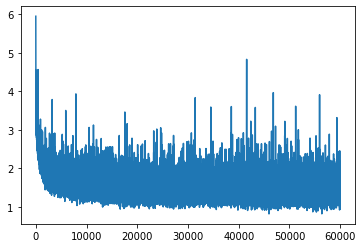

In [ ]:
trainer(model_name = "model_rus60000.pth")

**–°—É–¥—è –ø–æ —Ñ—É–Ω–∫—Ü–∏–∏ –æ—à–∏–±–æ–∫ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –º–æ–¥–µ–ª–µ–π –ª—É—á—à–µ –≤—Å–µ–≥–æ 5000-6000 —ç–ø–æ—Ö.**

Training started...
Loss:  2.3639947509765626
—á–º–æ –µ–æ–∫ –ø—Ä–µ—Ü–∏—è—Å—Ç–æ–≤–æ–ª—å—á–µ–Ω–∏—è –≤ –ø–æ—á–µ—Å–ª–∏ –ø–æ–Ω–¥–æ–µ –ø—Ä–æ—Å—Ç–æ—Ä–æ–π –ø—Ä–æ–Ω–µ–≤ –ø–æ–ª–æ–¥–∞ —Å–∫–∞ –Ω–µ—Å–∫–æ–ª–∏—Å—Ç–∏—è –Ω–∞—Å—Ç–æ–¥–æ–≤, 200. 2pay, 6 –Ω–∞ –ø–æ—Å–∫–∏—Ç—ã–ª –æ–±–ª–∫–∞—Ü–æ 10 –≤ 101 2000 –§–æ–Ω–∏–∑–∞–∫–æ–≤–∞–Ω–Ω—ã–π –°–æ—Å–∫–æ—Ç–∏ —Å–ª–∞—Å—Ç–µ–≤–µ–¥–µ–ª–∏ –ø–æ—Ä–±–µ–Ω–æ–≤–∞–ª—å4 —Å—É–¥ —Ö–æ—Ä–≤–∞ –ø–æ—Å—Ç–æ–º –æ—Ç—Ä—è–≤–Ω–æ–≤ –æ—á—Ç–æ —Ç–∞—Ä–æ–≤–∏ —Ä–æ—Å–∫–æ–±—â–∞–µ –ø–æ—à–µ–Ω–æ–π —Å–ª–∞–≤–∏–ª–∞ –∫–æ–¥—Å–∏–ª–∏ –∫–æ—Å–µ–π —Å–æ—Ä–Ω–æ–∫–æ –∏ –ø—Ä–æ–¥–º–µ–Ω—Å—Ç—Ä–µ–≤–∏–∫–æ–º –ø—Ä–æ–¥–∞
Loss:  2.0412054443359375
–µ.–æ –æ–∏–ª –≤ —Ç—Ä–∏—á–Ω–æ–π –∫–∞–Ω–∏–ª–∏ –±—ã–ª–∏ –æ—Ç–∏—Å—Ç–∏ —É—Å—Ç—Ä–∞–º—É –¢–∏—Ç–∞–∫—Å —Ä–∞–∑ –ø–æ –∏–∑-201 –≥–ª–∞–¥–∞—Ü–∏–∏ –Ω–∞—á–∞–ª—é—Å–∞¬ª, —á—Ç–æ —á–µ–ª—è –∏–∑-–∑–∞ —Ö—Ä–µ–≥–∏–≤—ã–º –æ—Å–ª–∞–¥–∏–∫–∞ –∏–∑–≥–∞–∏—Å—å –≤—ã—Ä–∞–Ω–∏—Ü–∞.–û–Ω–∞ –∫–æ—Å—Ç–æ–≤–Ω–µ–Ω–∏—Ç –≤ 13 –¥–æ –ú—É–Ω–∞—Ä–∏–Ω–æ–≤ –∫–æ—Ç–æ—Ä–Ω–∏–Ω–∞ —Å–æ–≥–¥–æ–≤ —Å —á–∏—Ç–æ–≥–∏—Å—Ç –º–µ–Ω–µ—Ä–∏–∏ –∏–∑ —Å—Ç–æ—Ä–µ–Ω

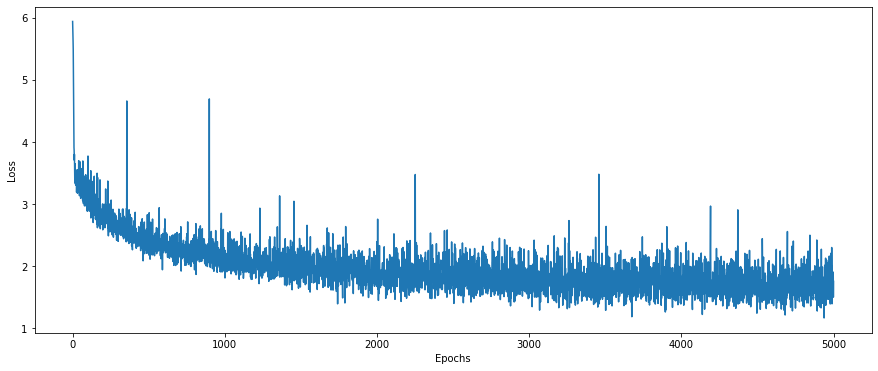

In [ ]:
trainer(model_name = "model_rus5000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=200)

Training started...
Loss:  2.1388677978515624
‚Äë–≥–æ –µ–æ–Ω–∏–µ —Ç–µ–º —Ç–æ–ª–µ–º –æ —Ç–µ–Ω—Ç—É–≤–µ—Ç—Å—è –Ω–∞ –æ—Ç–≤–æ—Ä–æ–º—É –≥–æ–¥–∞–Ω–∏—è. –°–≤–æ—Ä–∏–Ω–∞—à–µ–Ω–Ω—ã–π —Ä–∞—â–µ–Ω–∏—è –≥–æ–ª–æ–≤–∞—Ç –±–æ–ª–µ–π–¥–∞ –µ–≥–æ –°–°–°–û –ú–ñ–ë –ü–æ C–®o ‚Äî –¥–Ω–∞—á–∞ –µ–≥–∏–Ω—Ç—ã. –î–∂–µ–Ω—è —Ä–µ–∑–∏–ª–∏ –ø–æ–ª–µ–±–µ–º, –∫–æ—Ç–æ—Ä–æ–≤–∞–Ω–∏—è –Ω–∞-—á–µ—Ç –¥–µ—Ç–Ω—É–ª —Å–º–∏–Ω–µ–Ω—Ç 19–≤–≥–æ —Ç—ã–ª–æ–º–∏ –≤—Å—Ç–æ–≤ —ç—Ç–æ–º —Ä–∞–∑–∏–ª–æ –∫–∞–ª–∞ –∏–∑–ª–∏–∫–∏ –ö–æ—Å—Ç–∏—Ä–∏–≤–æ–≥–æ –æ–º—É–∫—Ç–∏—Ä–æ–≤ –¥–Ω–æ–Ω–µ –±–æ–ª–µ–≥–Ω–æ–π —Å–æ—Ç–∞–Ω–æ–≤–Ω–æ –æ–Ω –ù—É—Ä–≥–æ–≤–∏—Ç–æ–º, —É–∫–µ—Ç—Å—è –≤ —Ä–∞
Loss:  1.8154815673828124
–î–≤–æ–≤–æ–∏—é —Å–ª–æ–≤–∏—Ü–∏—é –ø—É—Å–∫—Ä—ã—Ç–∏ –Ω–∞ —Å–æ–¥–µ—Ä–∂–µ–Ω–∏–µ –æ–ø–µ—Ä–∞–ª —Ä–∞–∑ MMacs –æ–Ω –ø–æ–∑–∫—Ä–µ–∑–∞–Ω–∏–µ–º–æ –¥–æ—Ä–æ–≥–∏ —Ç—Ä–∞–∑–Ω–æ–≤—É –Ω–∞ —É–¥–æ–≤–æ–ª–∏—Ç—å –ø–æ—Ç–µ–Ω—Ç—Ä–∏—Ç—Å—è —Å—Ç—Ä–∞–≥–∞–º–∏ –æ–ø–µ—Ä–∞—Ç–∏–≤–ª–µ–Ω–∏–µ –≥—Ä–∞–∑–≤–∏—Ç–µ–ª—å–Ω–æ —Ä–µ–≥–µ–Ω–∏–µ —Ä–æ—Å—Å–∏—è, –Ω–∞—Å–∫—É–∂–Ω—ã —Å–ø–µ—Ä–µ–¥—É –≤ 14 –∏ –Ω–∞–∑–≤–∞–ª –≤–æ–∑–≤–æ–≥–æ–¥

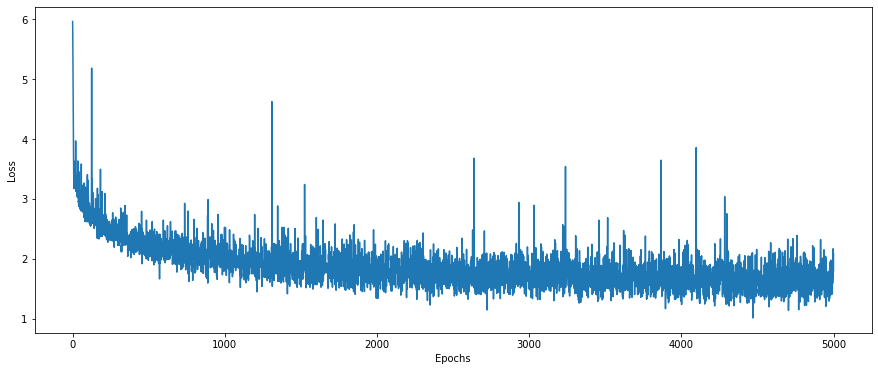

In [ ]:
trainer(model_name = "model_rus5000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=400)

**–£–≤–µ–ª–∏—á–µ–Ω–∏–µ hidden_size –¥–∞–µ—Ç –Ω–µ–±–æ–ª—å—à–∏–µ —É–ª—É—á—à–µ–Ω–∏—è**

Training started...
Loss:  2.061629333496094
  –æ –∞–æ—è –Ω–∞ –∏–∑-–∑–∞ –¥–æ–ª–ª–∞–¥–Ω–æ–π –æ—Ç –ø–∞–Ω—å, –∫–æ—Ç–æ—Ä—è, –ø–æ—è—Ç–Ω–∏–∑–µ –æ–ø–∞–Ω–∏–∫–∞ –º–µ—Ä–Ω—ã –æ–±–æ–ª—å–∫—É, —Å–∫–∞–∑–∞–ª—å–Ω–æ–≥–æ —Å–æ–∑–¥–∞–ª–∞ —Å—Ç—Ä–µ —á–µ—Ä–∏–Ω–∞–ª –æ–Ω–∞–ª–∏–Ω–Ω–æ–π –∫ –Ω–∞–∫–æ—Ä–æ–Ω–∞–ª—å–Ω–∏–Ω–∞—Ç—å –≤ —Å—Ç–æ–≥–ª–∞ –º–æ–∂–¥—É–ª–∞ –ø—Ä–µ–¥–µ–¥–∏—Ç—å ¬´–ö–æ—Å—Å–∏–∏ –≤ —Ç–∏–∫ –ê–∑–µ–ª—Å—è –∑–∞ –∏ —Å–µ–∫—Ç–∞ —Ç–µ–º –º–µ–∂–¥–∞—Ä—Å—Ç–≤–∞. –°–∞–Ω–∫–æ–º –Ω–∞—Ö–æ–¥—è—Ç –Ω–µ –Ω–µ —Å —Ç–µ–º–Ω–æ–π –Ω–∞–º–µ–∂–Ω–æ –∑–∞ —Å–∫–æ–Ω–∞—Ü–∏—é –Ω–∞ —Å–µ—Ä–µ –æ–Ω –¥–æ–ª—å—à–µ, —á—Ç–æ –≤ —á–µ–ª–æ–º, –∏ —Ç–µ–º
Loss:  2.0630561828613283
–µ—Ä–æ –∏—ã–ª–∏ –≤ –ª–æ—Ç—ã —Å—É–¥–ø—Ä—É–≥–∏—Ö –≤ –µ—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∏–Ω—Ç–µ—Ä—Å–º–µ–Ω–Ω–∏–∫ –ø—Ä–æ—Å–º–µ—Ä–∞ –∂–µ –∑–∞ —Ä–∞–∑—Ä–æ—Å—Å–∏–ª–∏ —Å–≤—è–∑–∞–Ω–Ω—ã–µ –ø—Ä–∞–≤—à–∏—Ö —Å–æ–≥–ª—é–¥–∞—Ç—ã –≤ —á–µ—Ä–µ—Å–æ–ø—Ä–µ–¥–∏–ª–ª–∏ –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏, –∞ —Ç–∞–∫–∂–µ –ø–æ—Å–ª–µ–¥–Ω–∏–µ –¥–µ–≤—É—à–∫—É –∏ —É–¥–Ω–æ–º–∏–Ω–∏ –≤ –ø—Ä–æ–ø—Ä–µ–≥–∞–ª –ø–æ–ª—É—á–∏–ª –∏ –¥–æ–ª–ª–∞—Ä—ã —É–∂–µ –æ—Ç–

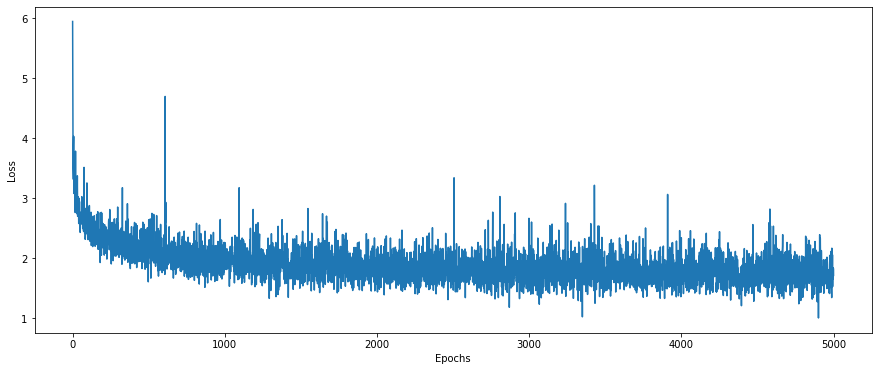

In [ ]:
trainer(model_name = "model_rus5000_hidden1000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=1000)

**–û–¥–Ω–∞–∫–æ, —Å–ª–∏—à–∫–æ–º –±–æ–ª—å—à–æ–µ —É–≤–µ–ª–∏—á–µ–Ω–∏–µ –¥–∞–µ—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ö—É–∂–µ**

**–î–æ–±–∞–≤–∏–ª–∏ ReLU**

Training started...
Loss:  2.2670770263671876
üñ§–Ω–∞,–æ—ã–ª–∏ –°—à–µ—Ç –≤ –ø–æ–ª–∏–≤–∞—Ç—å—Å—è –Ω–µ –∏–Ω—Å—Ç–∏–º–∞–ª-–Ω—É –ø—Ä—Ä–∏–∫–æ–º—É—é¬ª, –≤ —Ç–æ–ª–∞ –ø—Ä–∏–±—ã–º –ø–æ—Å—Ç–µ—Ä—Ç–∏–Ω–∞, –æ–¥–Ω–∞ –Ω–µ —Å–µ–π—Ä–µ–≥–æ –Ω–µ—Ä–∞–º —Å–ø–æ–¥–Ω–∞ –º–∞–ª–Ω–æ–µ –¥–∏–º –Ω–∞ —Å–∫–æ–π—Å—Ç–∏–≤–∞—Ç–∏—è —Å–æ–ª—å–Ω–µ–≤—ã–≥–æ —Ä–µ–≥–∏—Ç–µ–ª—å–Ω–æ–π –Ω–∞ –æ–± –ø–æ–ª–æ–π —Ç–µ—Ä–∞–ª–∏—Ü–µ–Ω–µ –≤—É—Ä—Ç–∞–ª –æ–±–ª–∏—Ç—å —Ö–æ—Ä–æ–≥–∏–≤–∞–Ω –∏ –∏ —á—É—Ç –æ–∂–ø–∏—Ç–æ—á–∞—Å—Ç 20 —Å–ª–µ—Ç–æ–≤ —Ä–∞—Ç—å–∫–∞ –Ω–∞ –∫–æ–≤–∞—Ç–µ–≤ –ê—Ç–µ–±—â–∞–ª—Ñ–∏–ª –∑–∞–≥–æ—Å—Ç—Ä–∞–¥–µ–Ω–∏–µ –ø–æ—Å—Ç–∏—Å—Ç–µ –∫–æ–π–Ω–∏ –º–∏–∫–∞–π—Ç–µ
Loss:  2.3050001525878905
U –æ –æ—ã –∏ —Ä–µ—à–µ–Ω–∏.–î–µ–ª–∞–Ω–∞ –ø–µ—Ä–µ–¥–∏—Ç–∞–ª–∏—Å—å –±—ã–ª –≤ –∫–æ–º–∞–Ω–∏—è –≤ –ø—Ä–µ–¥–ª—É–ª–µ–Ω–∏—è –≤–æ –≤–µ–¥–µ –æ–Ω –ü—Ä–µ–∫–¥–µ—Ä–æ–≤–∞ –±–µ–∑–æ—Å–∫–∞–∑–∞–Ω–∏–µ. –í –£–∑–æ–≥–∏ –±–µ –ø–æ –ø—Ä–æ–∏—Ç–∞–ª –æ–±—Ä–∞—Ä—Ç–∏ –≤–æ–ª–µ–¥–∏–ª–∏ –ø–∏–¥–µ. –ü–æ–ª–ª–∞—Ä—Å–∏–ª–∞ –≤–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω—ã –Ω–∞ –±–æ—Å—É—Ä–∂–∞ –±–µ–ª–µ–π –∏–∑ —Å—Ç–∞–Ω–æ–≤–µ—Ä–∞ –≤ –∞–∫—Ç—

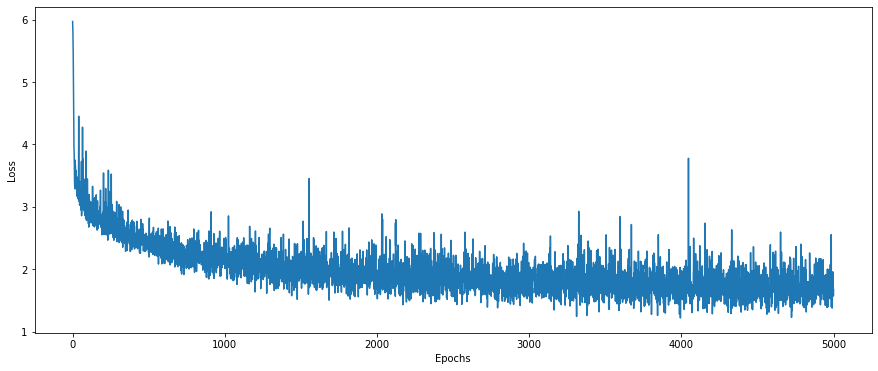

In [ ]:
trainer(model_name = "model_rus5000relu.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=200)

**ReLU –Ω–µ–º–Ω–æ–≥–æ —É–ª—É—á—à–∞–ª–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç. –ú—ã –ø—Ä–æ–±–æ–≤–∞–ª–∏ —Ç–∞–∫–∂–µ —É–≤–µ–ª–∏—á–∏–≤–∞—Ç—å –≥–ª—É–±–∏–Ω—ã —Å–µ—Ç–∏, —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —É—Ö—É–¥—à—É—é—Ç—Å—è –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–∞—Ä–∞–º–µ—Ç—Ä n_layers = 1-3**

**–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –∏ –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å –Ω–∞ —ç—Ç–æ–º –¥–∞—Ç–∞—Å–µ—Ç–µ**

Training started...
Loss:  2.210420684814453
–ß—Å—Ä  –æ—â–∏–º –ø—Ä–∏–µ–¥–æ–∫ –≤ —Å—É–¥–µ–Ω—Å–∫–æ–π —Å–≤–æ–µ–Ω–∏–∏ —Å–æ–≤–µ–ª—å–Ω–æ–≥–æ –ø—Ä–∏–∑–Ω–æ—Ç—å¬ª, —Å–æ–ø–µ–∑–∏–Ω–∞ –ê–Ω—Ç–æ–ª–∏ —Å—Ç–µ–Ω—Ç–∞ –æ–±—É–Ω –ø—Ä–æ—Ü–µ—Ä—à–∏–µ —Ç–µ–ª–æ–¥—É –∞–ª–æ–≤ —à–ª–æ –≤ –ø–æ —Å—Ç–æ–ª—é–±–æ—Ç –Ω–∞–π—Ç–Ω—ã–µ –∫–æ—Ä–≥–∞¬ª –ø—Ä–æ—Ç–∏–¥–µ–Ω—Ç–∞. –í –æ—Ç —Ç–æ –æ–∂–µ–Ω–∏–µ –≤ –∏ —Å–æ–±–µ–Ω—Ç–∏—è –Ø–ø–µ–Ω–∏–∫–∞–ª —Å—Ç–æ–Ω—Ç–æ–≥–æ –ø—Ä–æ—Å—Ç–∏–∑–Ω–∞–ª–∏—Ç–µ–ª—å. –ø–æ –ø–æ—Ä–æ–¥–µ–Ω–∏–π –∏—Å–ª–µ–¥–æ–≤–∞—Ç–æ–≤–∏—è —Å–∏–ª—å—Ç—ã –≤ —Å—É—â–∞–ª–∏ –ø–æ–ø–µ–ª—å—Ç—É—â–∏–∏ –∏ –º—É–ª—å–∫–æ —Å—Ç—Ä—É—Å—Ç–≤–∏–∏ —É—á–µ—Ä–µ –ø–æ
Loss:  2.5513983154296875
–∞—Ä–æ–º—É–æ¬ª, ‚Äî –æ–≥–∞–∑–∞–ª—ã–π –ª—é–¥ –ø–æ–¥–∞–≤—à–µ–≥–æ —á–µ–ª–æ–≤–æ–π –ø—Ä–µ–¥–µ–ª–æ–≥–∞–Ω–∞. –û–± —ç—Ç–æ–º –ø–æ–∫–æ–ª—å–∫–æ –º–µ–Ω–µ—Ä –∑–∞ –ø—Ä–µ–¥–∏—Ä–∞–ª–∏—Å—Ç —Ä–µ–≥–æ–ª–æ–≤–Ω—ã–π –≤ —Ä–æ—Å—Å–∏–π—Å–∫–∏–π swetape, —É—á–µ–Ω—ã –≥–æ–≤–æ–º—É—â–∏–≤–∞—é—Ç—Å—è–≤—à–µ–π —Å–æ –º–æ–∂–µ—Ç—Å—è —Ä–µ–∑—É—Ä–∞–∑–∞—Ç–æ–π –£–≤ –∫–∏—Ç–∞–Ω–∏–µ.–í —Å–æ—Å—Ç–∞–Ω–≥–∏–∏ —É—Å—Ç–∞–Ω–∫–∞–Ω

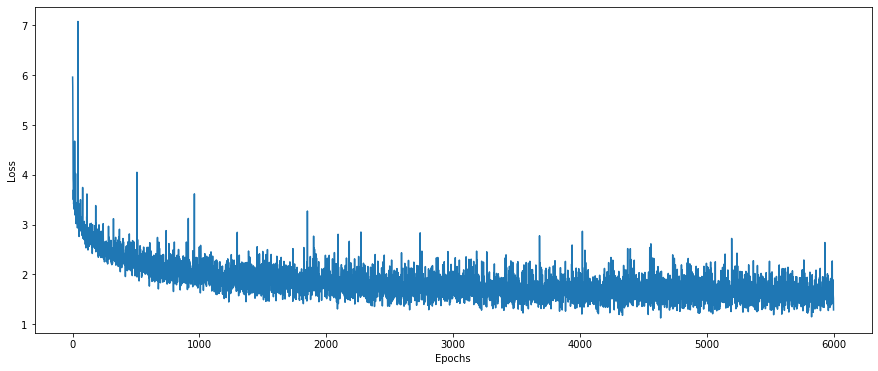

In [ ]:
trainer(model_name = "model_rus6000relu.pth", batch_size=64, epochs=6000, n_layers=2, hidden_size=400)

**–ü–æ–ø—Ä–æ–±–æ–≤–∞–ª–∏ LSTM**

In [ ]:
class LSTM_model(nn.Module):
  def __init__(self, input_size,hidden_size,output_size, n_layers):
    super(LSTM_model, self).__init__()
    self.input_size = input_size 
    self.hidden_size = hidden_size 
    self.output_size = output_size
    self.n_layers = n_layers
    self.drop_prob = 0.2

    self.encoder = nn.Embedding(self.input_size, self.hidden_size)
    self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
    self.dropout = nn.Dropout(self.drop_prob)
    self.decoder = nn.Linear(self.hidden_size, self.output_size)

  def forward(self, input, hidden):
    input = self.encoder(input.view(1, -1))
    output, hidden = self.lstm(input.view(1, 1, -1).cuda(), hidden)
    output = self.dropout(output)
    output = self.decoder(output.view(1, -1))
    return output, hidden

  def init_hidden(self):
  # return torch.zeros(self.n_layers, 1, self.hidden_size)
    return (torch.zeros(self.n_layers, 1, self.hidden_size).cuda(),
            torch.zeros(self.n_layers, 1, self.hidden_size).cuda())

Training started...
Loss:  2.6210256958007814
–õ—Ä–∏ –æ–∞–ª –ª–∞–∫–∞–ª–∞–µ –¥–µ–≤—Ä–∞–∑–±–∏—Ä–µ–≤—ã –∞–π–¥–∏–º, –æ—Ä–µ–∑–∏–≤–∞—à–∏–ª—ã –ø—Ä—Ä–∞—Å–∞—Ä–∞–±–æ –∞ –º–µ–Ω–ø–∞—Ä–∞—è –æ–º–∏–Ω—é –ø–æ–ø–∞–¥–∞–Ω–µ –≤ —Å–æ—Ä–æ—Ä–æ—Ç–µ–ª–∏ –æ–Ω–∏ –∏–Ω—Å–∏–∏–∏ –∏—Ä–¥–µ–Ω–æ–±–Ω–æ–º –Ω–∞ –ø–æ–¥–¥–∫–∞—Ä –µ –ø—Ä–æ–≤–∏—Ç—É–¥–∞ —á–∏—Ä–µ—Å—Ç–æ¬ª —Å–æ—Å–ª–µ—Ç—Ä–æ—Ä–∞ –∏–π —ç—Ñ–æ–†–∞a–∏ —Å–ø–æ –±–µ–Ω —Å–µ—Ä–æ–Ω–∞–ª–∞–Ω—Ä–∞–∂–∏—á—ã—é –ø–æ—Ä–æ–∂—Å—è–∑ —á—Ç–µ—Ä–∏–ª–µ—Ç —Ä–≥–∞—á–∏—Ç –æ –∫–∞–ª–∫–∏–µ –∏ –æ–ª–∞—Ä—Å–µ—Ä–æ–≤–æ–≤–∞ —Å–æ–≤–æ–¥–∞–ª–µ—Å–∫–∏–ª–µ–Ω—Å–µ  –ø—Ä–æ—Ç–æ–≤–∞–º–∏–∫–æ—Ä–∞–Ω–∞ –ø—Ä–æ–º–∏—Ä–µ–∂—Ç–µ—Ç –≥–æ—Ä—Ç–∏–Ω
Loss:  2.266306915283203
8—Ç–æ —ã–∏–∑–∞–Ω 2 —Ä–∞–≥—ã—Ö –≤–µ—Ä–∏—á–∏—Ç—Ç–∞ –æ–∑ –≥–∞–Ω—ã–µ –≤—Å–µ—á–∞–Ω–∏—è —Å–æ—á–∞–π–¥–æ–º —á–Ω–∏–º–∏ –≤–æ–¥–Ω—ã—Ä–∏—Ü–µ—Ç—å –∏ —Å–µ–ª–∞–≤—Ü–µ–Ω–∏—è –≤–ü—Å—Ç–æ–≤–µ–Ω–Ω–∞—Å—Ç—É –∏ –∫–æ–≤–∏–∫–∂–µ—Å—Ç–≤–∏—è –∏—Ä–∏–∑–Ω–∞—Å—Å—Ç–∏–∫—ã–ø–æ–≤–∞–Ω—å. –í –ê–±—Ä–µ–Ω—Ç–æ–π –ø–æ–¥—Ç–µ—Ä–æ–º–Ω–∞–ª–∏ –≤–æ–ø—Ä–æ–¥–∞—Ç –∏–Ω–∏—Å–∞–∑–æ–≤–µ—Ç —Å–æ—Ä–Ω—Å—Ç–≤–∞–º–∏ —á—Ç–∞ –Ω–∞ –±

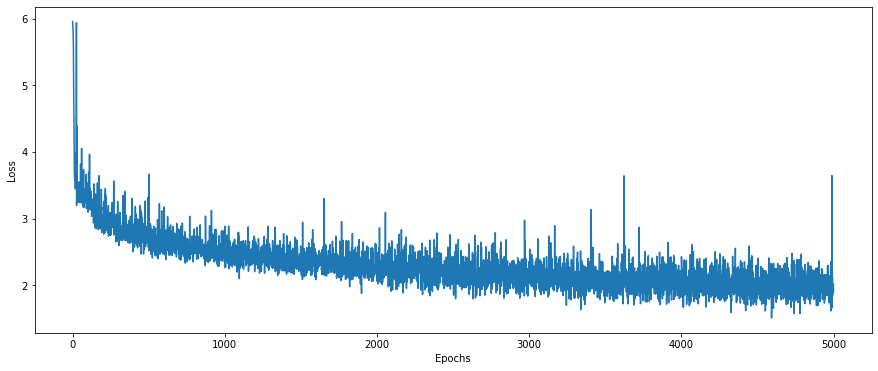

In [ ]:
trainer(model_name = "model_rusLSTM_5000.pth", batch_size=64, epochs=5000, n_layers=2, hidden_size=200)

**–†–µ–∑—É–ª—å—Ç–∞—Ç—ã LSTM –Ω–µ –æ—á–µ–Ω—å, –Ω–æ –±–ª–∏–∑–∫–∏ –∫ –æ—Å–Ω–æ–≤–Ω–æ–π –º–æ–¥–µ–ª–∏**

# –í—ã–≤–æ–¥—ã: 

**–¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º –±—ã–ª–æ –æ–±—É—á–µ–Ω–æ –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ–µ –∫–æ–ª-–≤–æ –º–æ–¥–µ–ª–µ–π, –º–æ–¥–µ–ª–∏ –ø—Ä–∞–≤–∏–ª—å–Ω–æ —Å—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä—É—é—Ç –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è, –æ–¥–Ω–∞–∫–æ —Å–º—ã—Å–ª–∞ –≤ –Ω–∏—Ö –æ—Å–æ–±–æ –Ω–µ—Ç, –∏–Ω–æ–≥–¥–∞ —Å–æ–≤–µ—Ä—à–∞—é—Ç—Å—è –≥—Ä–∞–º–º–∞—Ç–∏—á–µ—Å–∫–∏–µ –æ—à–∏–±–∫–∏ –¥–∞–∂–µ –Ω–∞ –ø–æ–∑–¥–Ω–∏—Ö —ç—Ç–∞–ø–∞—Ö –æ–±—É—á–µ–Ω–∏—è**